# Live-coding script for OpenNeuromorphic Rockpool / Xylo demo April 2023
Dylan Muir
## Outline
 1. ``LIF`` module, spiking neuron
 4. How to compose a network
    - `Linear` weights
    - `Sequential` combinator
    - `Residual` combinator
 5. Audio task
    - Introduce SHD
 6. Network architecture
 7. Training
 8. Xylo architecture
 9. Mapping, quantization, deployment
 10. Inference using ``XyloSim``
 11. Inference on Xylo HDK


This live-coding script demonstrates working with Rockpool to train SNN networks for Xylo, on an audio task.

First we need to install the required packages.

In [1]:
# - Install requirements for this notebook
%pip install --quiet rockpool matplotlib torch tonic rich tqdm jax jaxlib xylosim samna bitstruct

# - Import and configure matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams["figure.dpi"] = 300

# - Nice printing
from rich import print

# - Torch and numpy
import torch
import numpy as np

# - For displaying images
from IPython.display import Image


Note: you may need to restart the kernel to use updated packages.


Rockpool is a deep learning library for SNNs, designed to make it very easy to design, train and deploy applications to neuromorphic hardware.

Documentation: https://rockpool.ai

In [2]:
# - The LIF module is a Leaky Integrate and Fire spiking neuron
from rockpool.nn.modules import LIF

In [3]:
# - Create a single LIF neuron to examine
lif = LIF(1, threshold=10.)
print(lif)

LIF  with shape (1, 1)

In [4]:
# - Generate some Poissonian spiking input to the neuron
f = 0.02
T = 500
Nin = 1
input_sp = np.random.rand(T, Nin) < f

# - Evolve the neuron by passing the data through
#   `record = True` records and returns internal state
out, _, rec_dict = lif(input_sp, record = True)

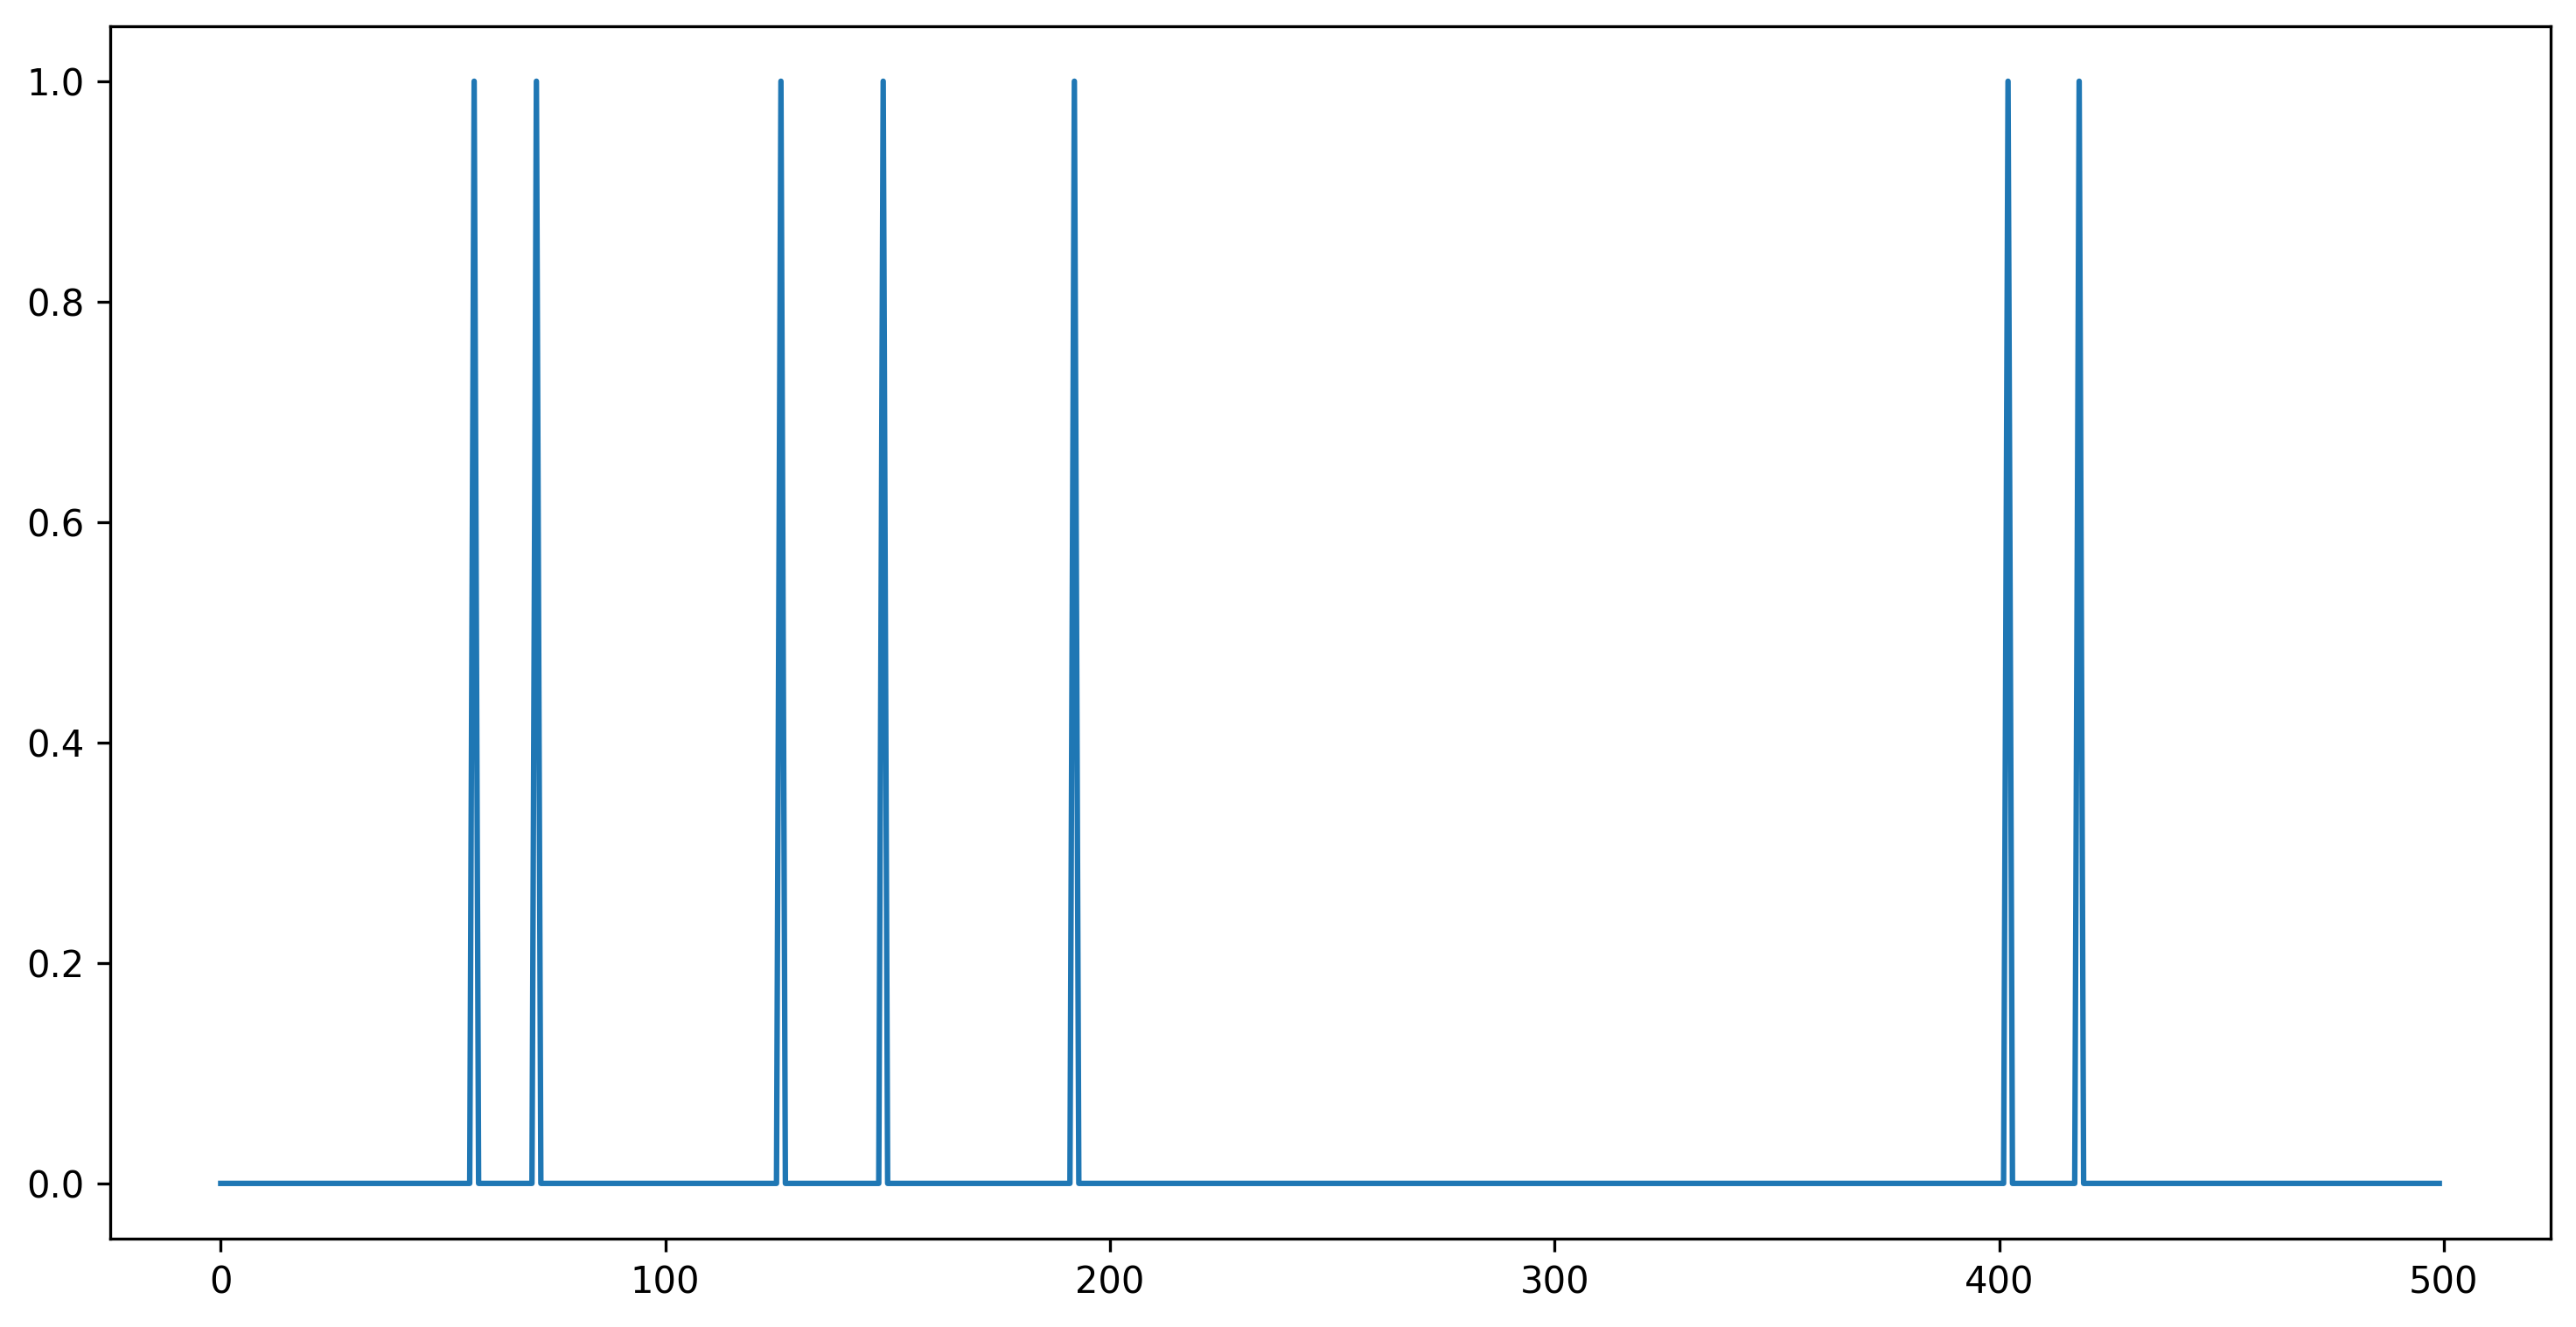

In [5]:
# - plot the output events
plt.plot(out.squeeze())

In [6]:
# - Let's look at the recorded state. What did we get back from the evolution?
rec_dict.keys()

dict_keys(['irec', 'spikes', 'isyn', 'vmem', 'U'])

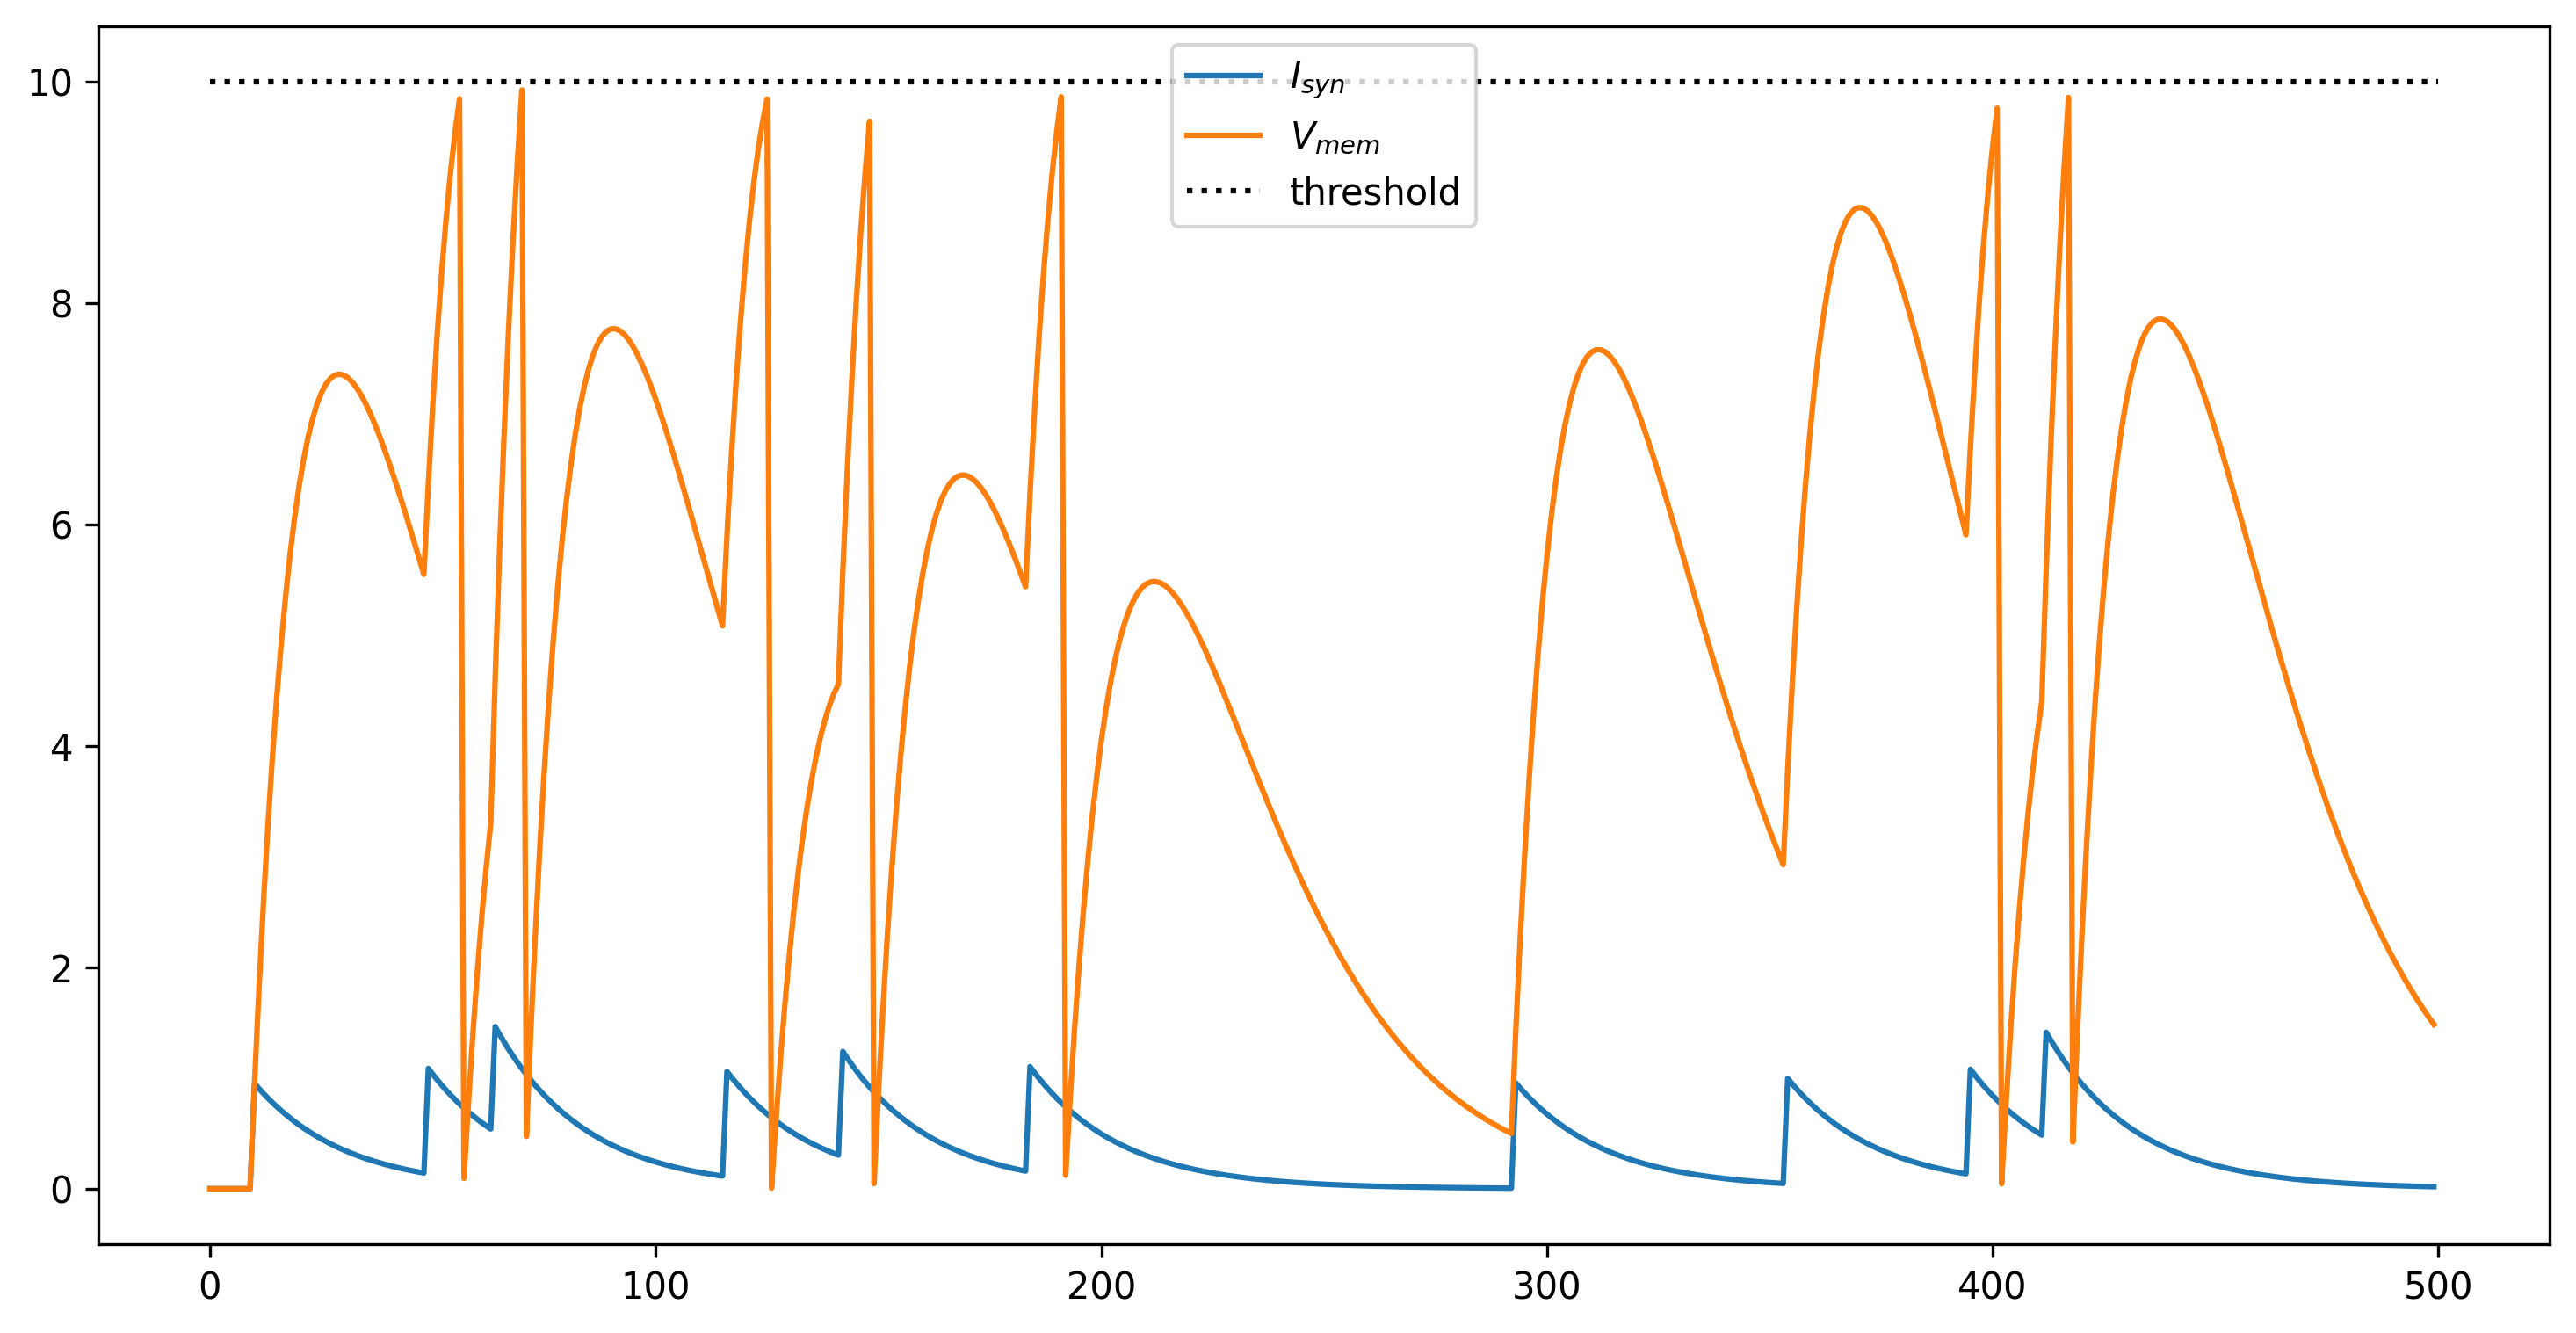

In [7]:
# - Let's plot the synaptic current `isyn` and membrane potential `vmem`
plt.plot(rec_dict['isyn'].squeeze(), label='$I_{syn}$')
plt.plot(rec_dict['vmem'].squeeze(), label='$V_{mem}$')
plt.plot([0, 500], [10, 10], 'k:', label='threshold')
plt.legend()

In [8]:
# - Rockpool modules all have a `state()` method which returns the internal module state
print(lif.state())

{'spikes': array([0.]), 'isyn': array([[0.01823255]]), 'vmem': array([1.48418795])}

In [9]:
# - Rockpool modules all have a `parameters()` method which returns the trainable parameters of a module
print(lif.parameters())

{'tau_mem': array([0.02]), 'tau_syn': array([[0.02]]), 'bias': array([0.]), 'threshold': array(10.)}

In [10]:
# - Rockpool modules all have a `simulation_parameters()` method which returns the non-trainable parameters
print(lif.simulation_parameters())

{'dt': 0.001, 'noise_std': 0.0, 'max_spikes_per_dt': 65536.0}

Obviously a single LIF neuron is not particularly useful. We need to be able to compose arbitrary network architectures. Now let's see how to build up a network in Rockpool.

We'll use a simple feed-forward network architecture here.

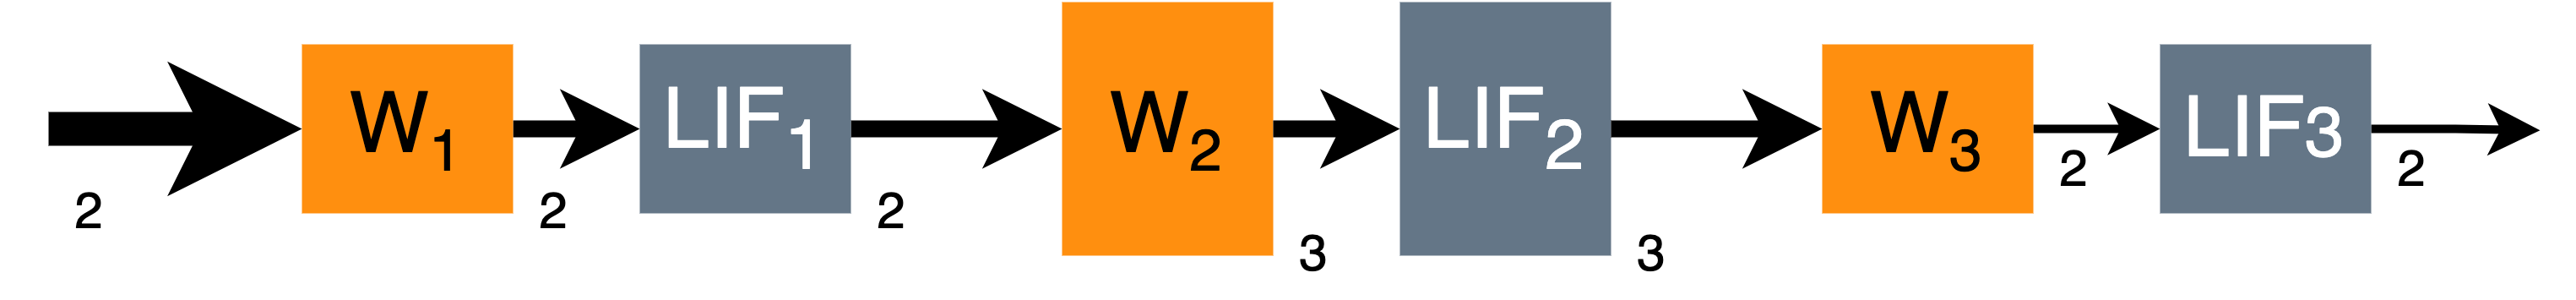

In [11]:
Image('images/network-layout-small.png')

In [12]:
# -  Import the required modules. `Linear` is a set of linear weights
from rockpool.nn.modules import Linear, LIF

# - `Sequential` is a combinator that puts modules in a sequence
from rockpool.nn.combinators import Sequential

In [13]:
# - We simply specify the modules in a sequence
net = Sequential(
    Linear((2, 3)),
    LIF(3),
    
    Linear((3, 3)),
    LIF(3),

    Linear((3, 2)),
    LIF(2),
)

print(net)

ModSequential  with shape (2, 2) {
    Linear '0_Linear' with shape (2, 3)
    LIF '1_LIF' with shape (3, 3)
    Linear '2_Linear' with shape (3, 3)
    LIF '3_LIF' with shape (3, 3)
    Linear '4_Linear' with shape (3, 2)
    LIF '5_LIF' with shape (2, 2)
}

In [14]:
# - The network itself is a module, with parameters, state, etc.
print(net.parameters())

{
    '0_Linear': {
        'weight': array([[ 0.54314858, -0.24875258,  0.78020442],
       [ 0.96888448,  1.48164615,  0.72165585]])
    },
    '1_LIF': {
        'tau_mem': array([0.02, 0.02, 0.02]),
        'tau_syn': array([[0.02],
       [0.02],
       [0.02]]),
        'bias': array([0., 0., 0.]),
        'threshold': array([1., 1., 1.])
    },
    '2_Linear': {
        'weight': array([[ 0.49773314,  0.24060837, -1.25092049],
       [ 0.57930747, -1.40704582,  1.1974073 ],
       [-0.01553628,  0.11515282, -1.13620568]])
    },
    '3_LIF': {
        'tau_mem': array([0.02, 0.02, 0.02]),
        'tau_syn': array([[0.02],
       [0.02],
       [0.02]]),
        'bias': array([0., 0., 0.]),
        'threshold': array([1., 1., 1.])
    },
    '4_Linear': {
        'weight': array([[-0.15479196,  0.26229377],
       [-1.2874902 , -0.27373414],
       [-0.59334312, -0.81820434]])
    },
    '5_LIF': {
        'tau_mem': array([0.02, 0.02]),
        'tau_syn': array([[0.02],
       [0.02]]),
        'bias': array([0., 0.]),
        'threshold': array([1., 1.])
    }
}

In [15]:
print(net.state())

{
    '0_Linear': {},
    '1_LIF': {
        'spikes': array([0., 0., 0.]),
        'isyn': array([[0.],
       [0.],
       [0.]]),
        'vmem': array([0., 0., 0.])
    },
    '2_Linear': {},
    '3_LIF': {
        'spikes': array([0., 0., 0.]),
        'isyn': array([[0.],
       [0.],
       [0.]]),
        'vmem': array([0., 0., 0.])
    },
    '4_Linear': {},
    '5_LIF': {'spikes': array([0., 0.]), 'isyn': array([[0.],
       [0.]]), 'vmem': array([0., 0.])}
}

# BACK TO POWERPOINT for SHD intro

``tonic`` is a package for managing neuromorphic datasets (https://tonic.readthedocs.io)

We'll use tonic to download the Spiking Heidlberg Digits dataset (https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/), and provide a convenient python `torch`-like dataset.

``tonic`` also provides data transformations and caching.

In [16]:
# - Import tonic, download and import the SHD dataset
import tonic
train_data = tonic.datasets.SHD('./data')
shd_timestep = 1e-6
shd_channels = 700
shd_classes = 20

/Users/dylan/SynSense Dropbox/Dylan Muir/LiveSync/Development/Projects/onm_20230426/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


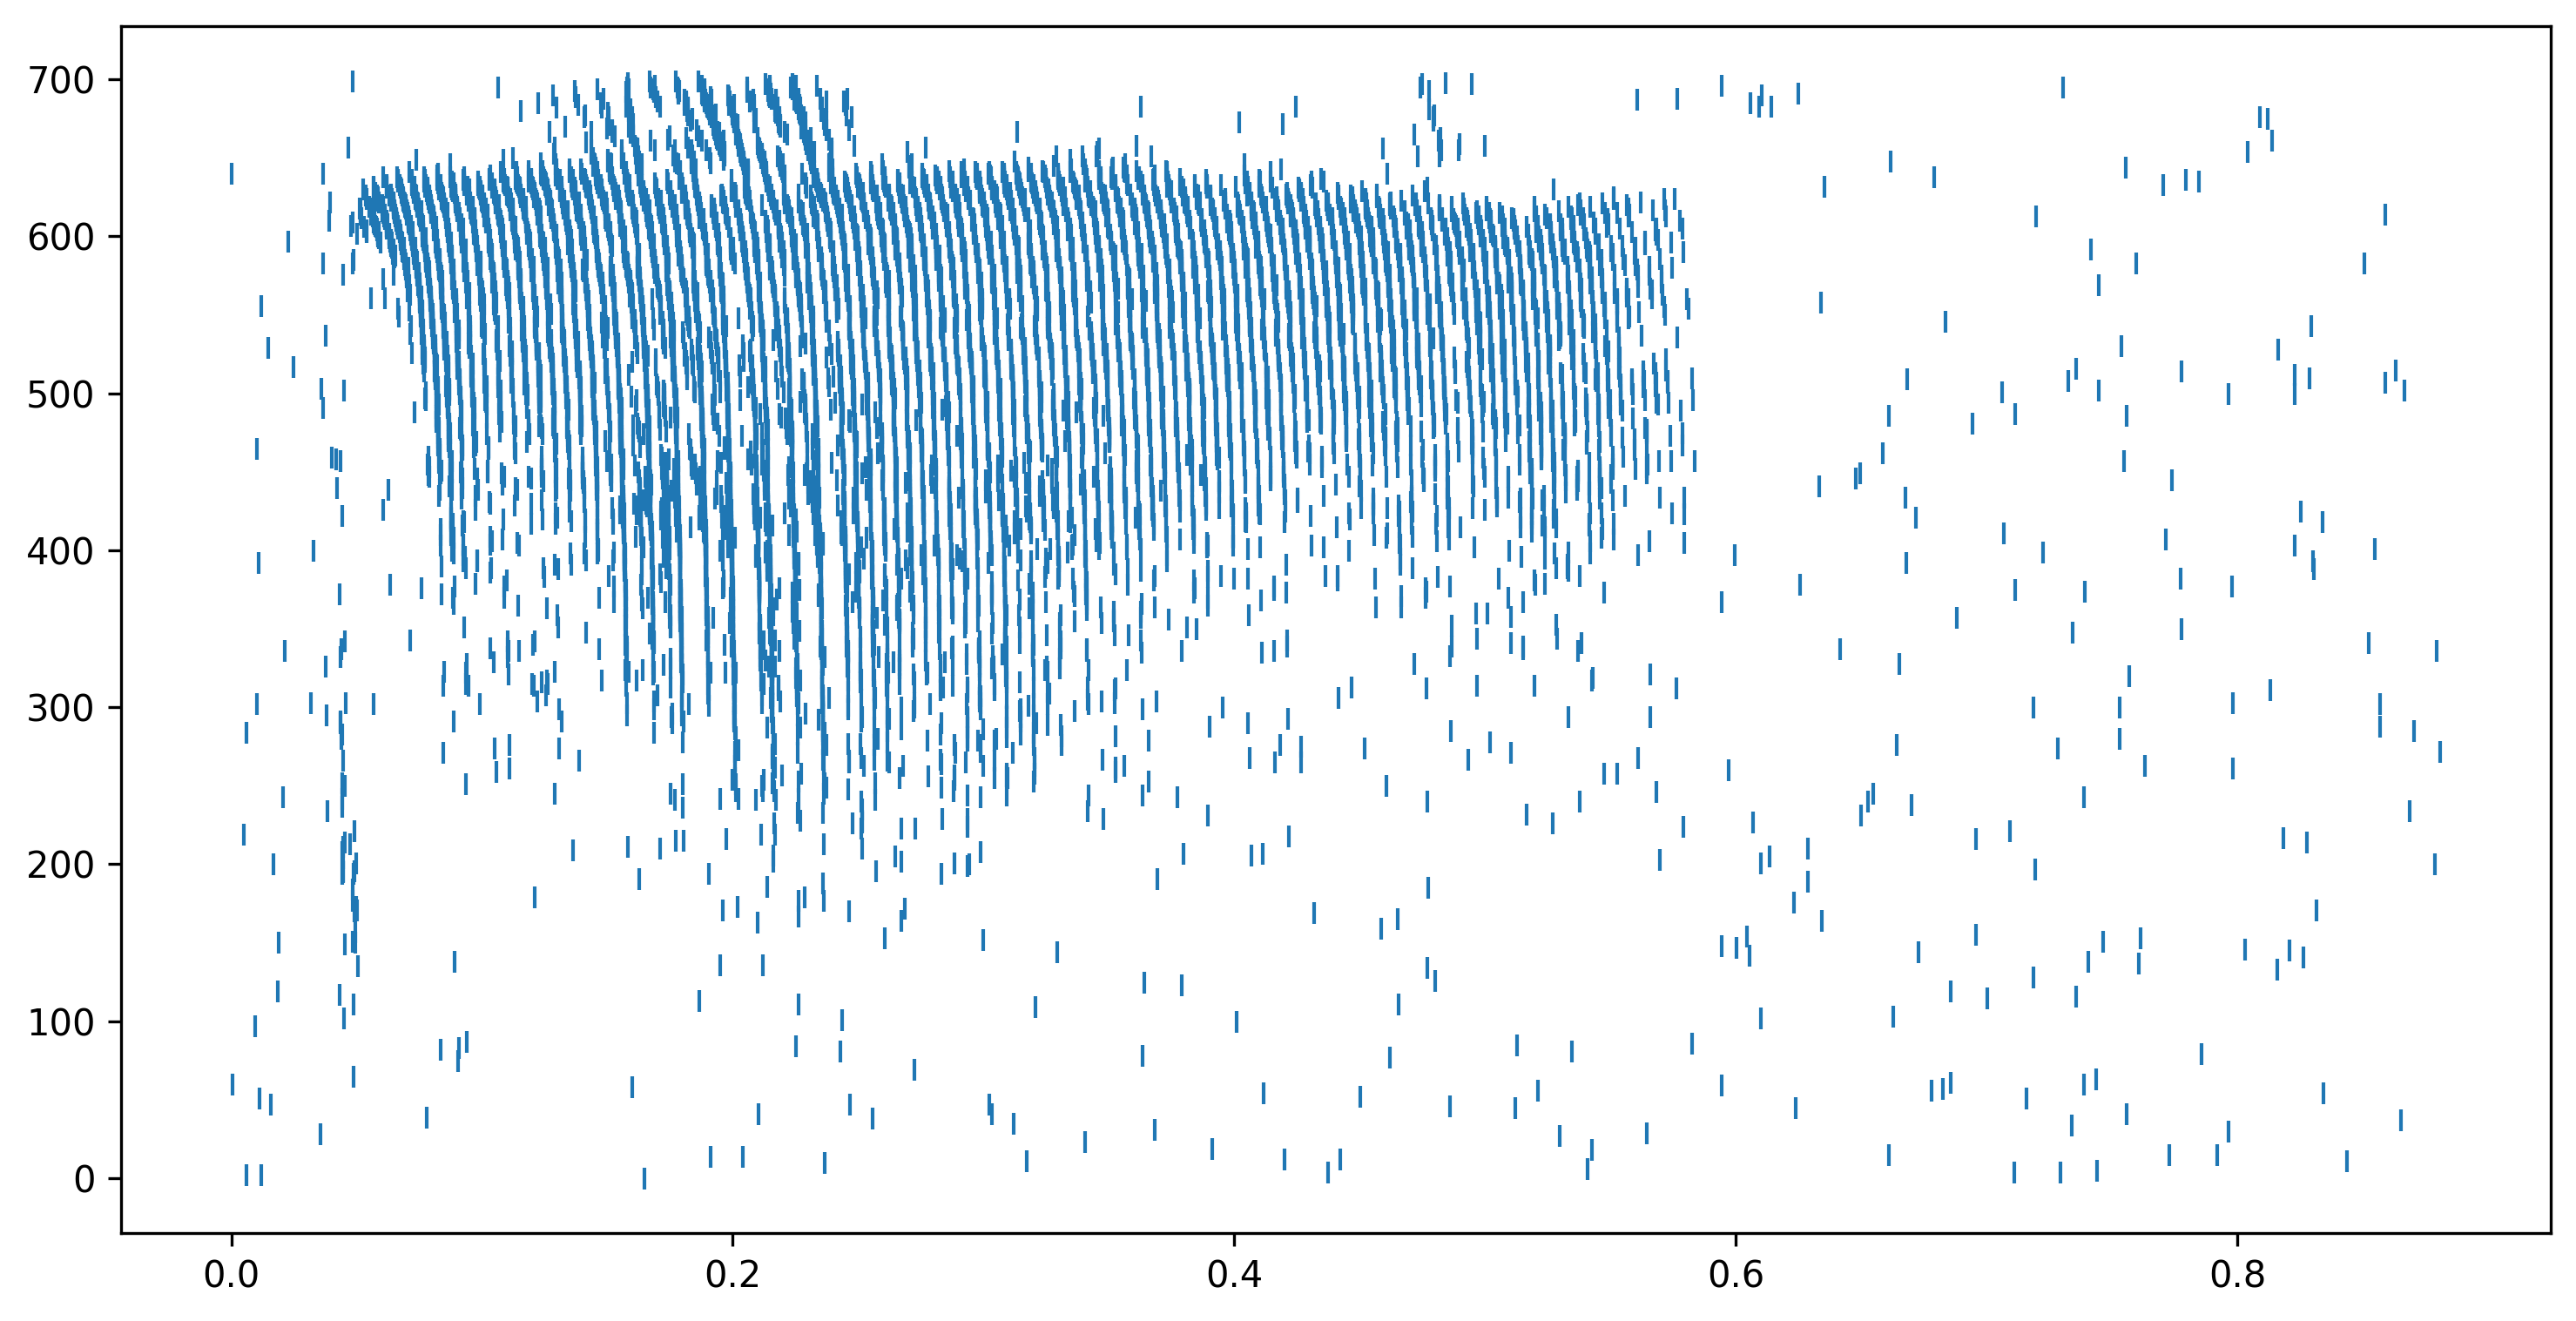

In [17]:
# - Let's examine one sample of the dataset
events, label = train_data[1]
times = events['t'] * shd_timestep
channels = events['x']
plt.plot(times, channels, '|')

In [18]:
# - We need to downsample the data to use it (to make the network and training simpler)
net_channels = 16
net_dt = 10e-3
sample_T = 250

In [19]:
# - We'll use `tonic` to downsample in 

import tonic.transforms as T

transform = T.Compose([
        # - Downsample in time and space
        T.Downsample(
            time_factor=shd_timestep / net_dt,
            spatial_factor=net_channels / shd_channels
            ),

        # - Rasterise the events
        T.ToFrame(
            sensor_size=(net_channels, 1, 1), time_window=1
        ),
        
        # - Convert to a tensor
        torch.Tensor,

        # - Make sure the samples are not too long in time
        lambda m: torch.squeeze(m)[:sample_T, :],
        ])

In [20]:
# - Reload the dataset with these transformations
train_data = tonic.datasets.SHD('./data', transform=transform)

In [21]:
# - Get one training sample
raster, label = train_data[1]

# - Extract spike times
times, channels = torch.where(raster)

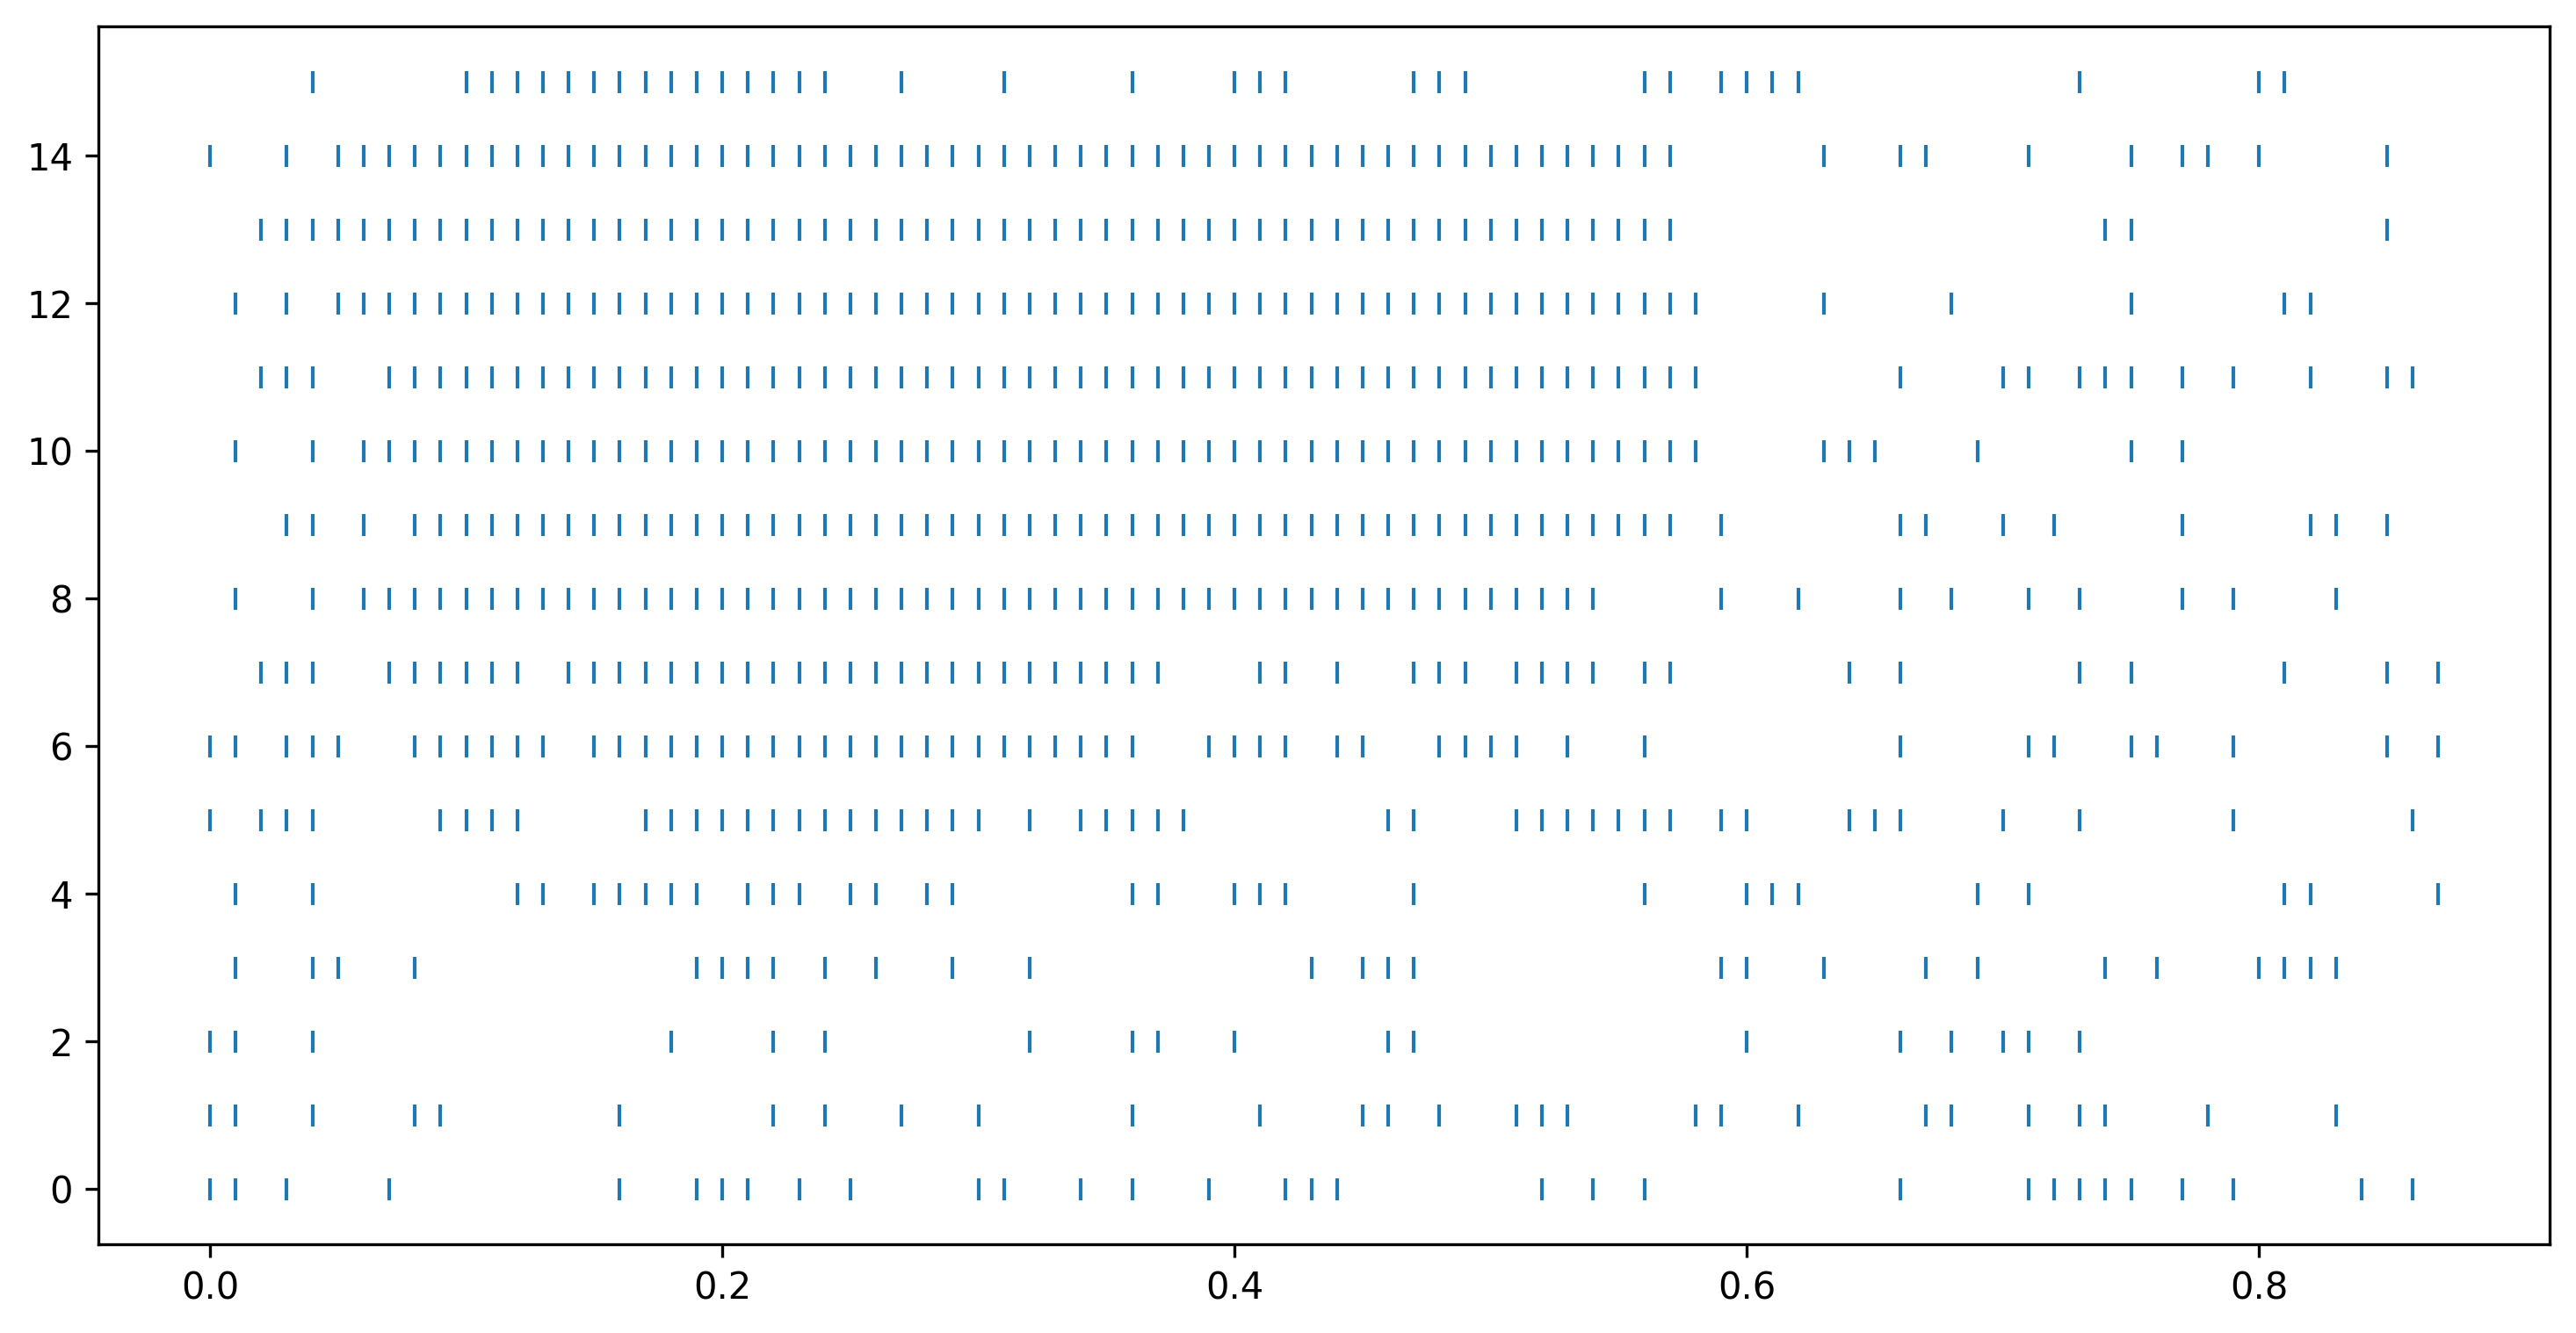

In [22]:
# - Plot this sample
plt.plot(times * net_dt, channels, '|')

Now we create a data loader to use in training. This is a standard `torch` dtaa loader, so I'm going to gloss over this cell.

We will select only the first 8 class labels to use, since Xylo only supports 8 output channels.

We will creata a data loader, using ``tonic`` to provide disk caching of the data. In-memory caching is also supported by ``tonic``, but not used here.

In [23]:
# - Create a class which subsets a dataset to a list of matching labels
class SubsetClasses(torch.utils.data.Dataset):
    def __init__(self,
                 dataset,
                 match_labels,
                 ):
        indices = []
        for idx in range(len(dataset)):
            _, label = dataset[idx]
            if label in match_labels:
                indices.append(idx)

        self._subset_ds = torch.utils.data.Subset(dataset, indices)
        self._len = len(indices)

    def __getitem__(self, index):
        return self._subset_ds[index]
    
    def __len__(self):
        return self._len

# - Define arguments for the data loader
dataloader_kwargs = dict(
    batch_size=128,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    collate_fn=tonic.collation.PadTensors(batch_first=True),
    num_workers=0,
)

# - Create the data loader, using `tonic` to provide a disk cache
train_dl = torch.utils.data.DataLoader(
    tonic.DiskCachedDataset(
        dataset=SubsetClasses(train_data, range(8)),
        cache_path=f"cache/{train_data.__class__.__name__}/train/{net_channels}/{net_dt}",
        reset_cache = False,
    ),
    **dataloader_kwargs
)

Now we'll define and train an SNN for the SHD task, to deploy to Xylo. We'll use the ``torch`` backend of Rockpool, which uses the PyTorch automatic differentiation pipeline to train NNs.

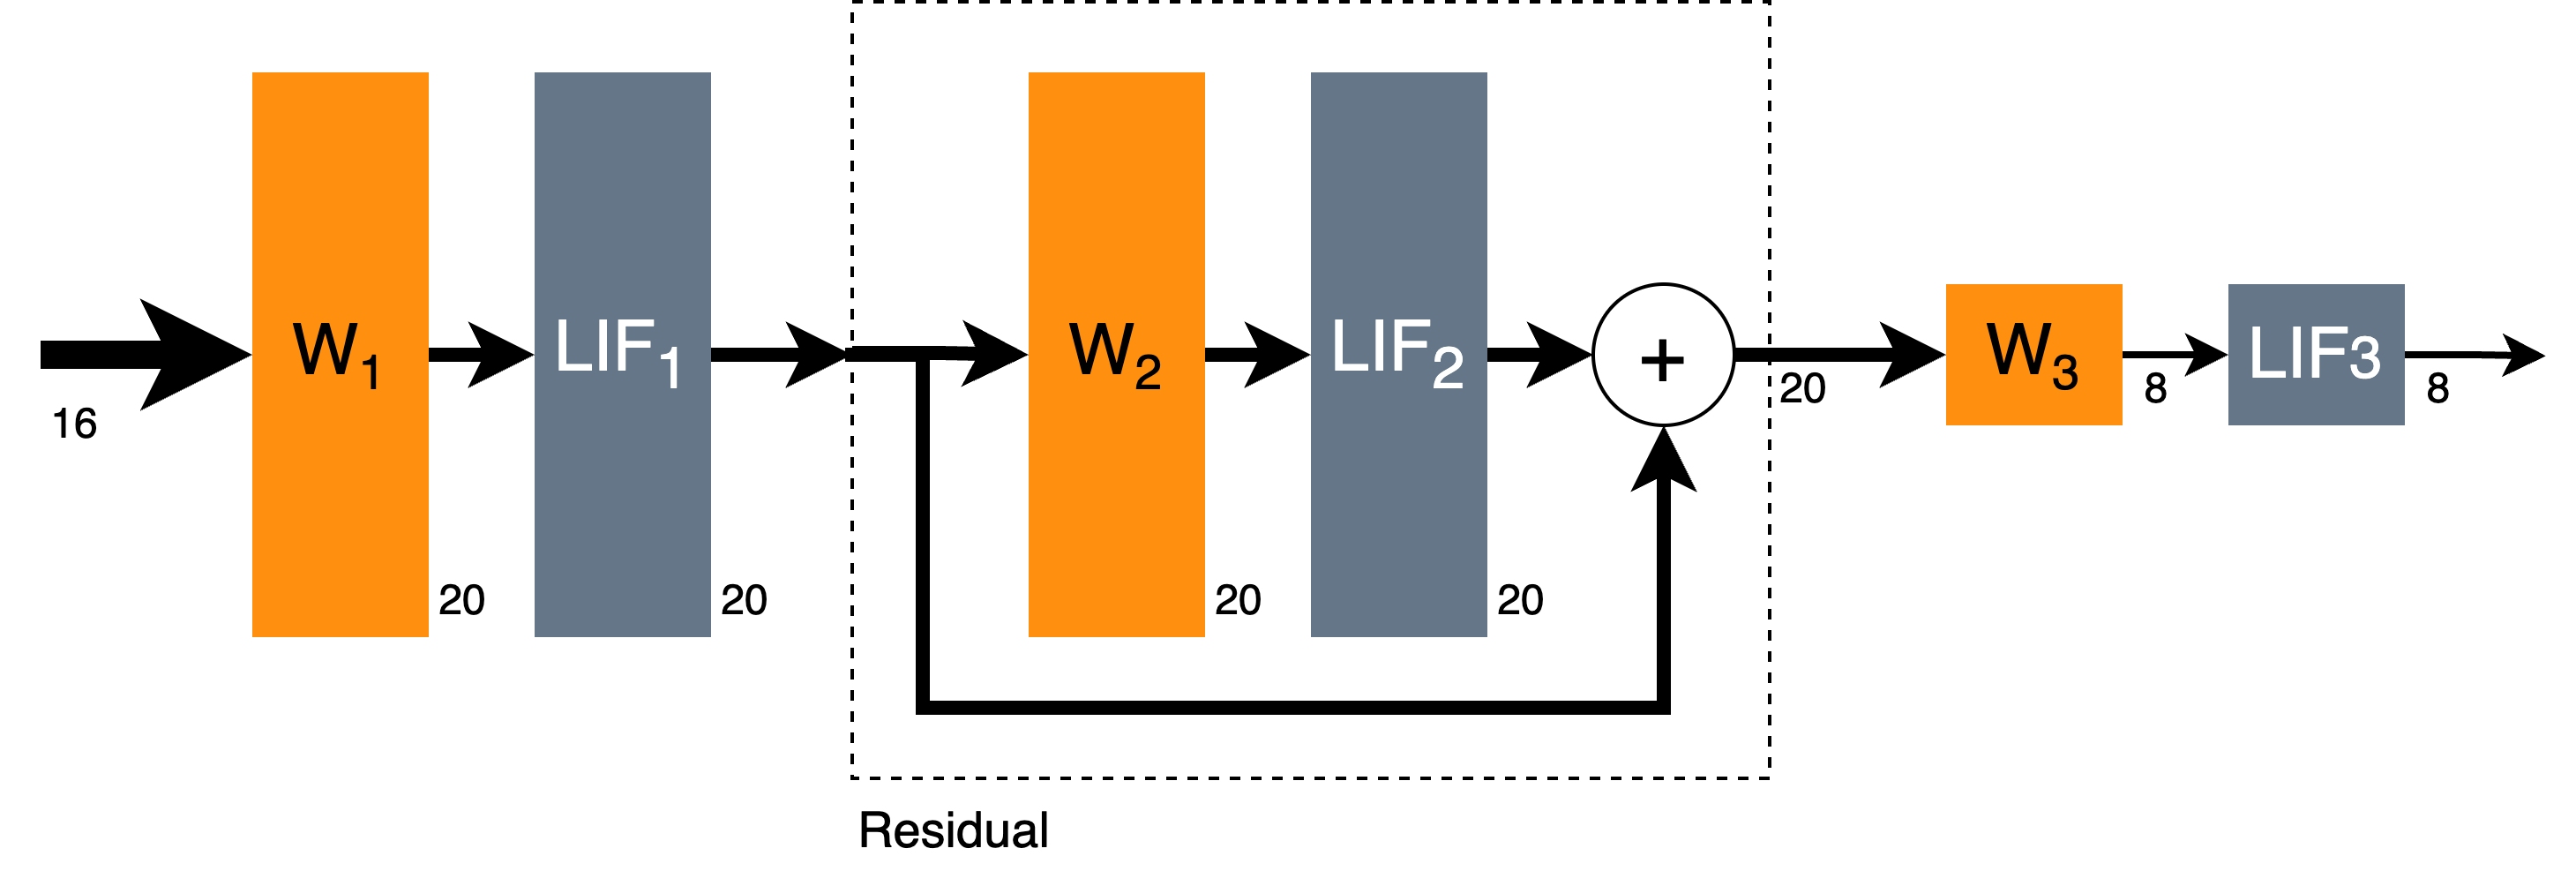

In [24]:
# - Show an image of the target network architecture
Image('images/network-layout-shd.svg.png')

In [25]:
# - Import the required torch-backed modules and combinators
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual

# - Define a simple network architecture
Nin = net_channels
Nhid = 20
Nembed = 8
Nout = 8

net = Sequential(
    LinearTorch((Nin, Nhid)),
    LIFTorch(Nhid),

    Residual(
        LinearTorch((Nhid, Nhid)),
        LIFTorch(Nhid),
    ),

    LinearTorch((Nhid, Nout)),
    LIFTorch(Nout),
)
print(net)

TorchSequential  with shape (16, 8) {
    LinearTorch '0_LinearTorch' with shape (16, 20)
    LIFTorch '1_LIFTorch' with shape (20, 20)
    TorchResidual '2_TorchResidual' with shape (20, 20) {
        LinearTorch '0_LinearTorch' with shape (20, 20)
        LIFTorch '1_LIFTorch' with shape (20, 20)
    }
    LinearTorch '3_LinearTorch' with shape (20, 8)
    LIFTorch '4_LIFTorch' with shape (8, 8)
}

In [26]:
# - By default all parameters are trainable
print(net.parameters())

{
    '0_LinearTorch': {
        'weight': Parameter containing:
tensor([[-0.5567,  0.0533, -0.5946, -0.4494,  0.3207, -0.4209,  0.1751, -0.0640,
          0.5130, -0.1162, -0.4183, -0.1693, -0.1952,  0.2957, -0.4851,  0.3415,
         -0.2853,  0.4268,  0.1383,  0.6012],
        [ 0.5259,  0.0052,  0.2055,  0.1970,  0.3625,  0.1005, -0.3929,  0.1678,
          0.3647,  0.1127, -0.2526, -0.3536, -0.4299,  0.1242,  0.5622,  0.0358,
         -0.2557,  0.0525,  0.1371,  0.0085],
        [ 0.0662, -0.2935,  0.4307,  0.3311,  0.5693,  0.3897, -0.3937,  0.1117,
         -0.1798,  0.0945, -0.5455,  0.1178, -0.5091, -0.3836,  0.3274,  0.5739,
         -0.4119,  0.4614, -0.0293, -0.3930],
        [ 0.2169, -0.5897, -0.0253,  0.2937, -0.4106, -0.4581, -0.3671,  0.5508,
         -0.2329,  0.3943,  0.1954, -0.0879, -0.3882,  0.4071,  0.1059, -0.5493,
         -0.3608, -0.3936, -0.4446,  0.5340],
        [ 0.1045,  0.0109, -0.3460,  0.3225, -0.4753, -0.5037, -0.1694, -0.2183,
         -0.3894, -0.5520,  0.1406,  0.2995, -0.1045,  0.3939, -0.4266, -0.0472,
         -0.1233,  0.5910,  0.4987,  0.0091],
        [ 0.2679,  0.5505, -0.4464, -0.2029,  0.5231,  0.4260, -0.2725,  0.1423,
         -0.4299,  0.2381, -0.4683,  0.3504, -0.4535, -0.0358, -0.1192, -0.5485,
          0.4641, -0.4254, -0.3886,  0.0489],
        [-0.2914,  0.5480, -0.3892, -0.1795, -0.3887, -0.4546,  0.3001,  0.3161,
          0.3667,  0.2970, -0.4620, -0.4176,  0.5028,  0.2950, -0.1539, -0.5427,
          0.5173,  0.3652,  0.5542,  0.1035],
        [ 0.5481, -0.5939,  0.0217,  0.3416, -0.2027,  0.5671,  0.4344,  0.3634,
          0.2423,  0.4399,  0.3154, -0.5398, -0.5398, -0.1419, -0.4128, -0.3989,
          0.4899,  0.1221, -0.5391, -0.1865],
        [ 0.1561, -0.2689,  0.3925,  0.3795,  0.0939,  0.1668, -0.2108, -0.2024,
         -0.2136, -0.1057, -0.2859, -0.1393, -0.5637,  0.1959, -0.4687, -0.0176,
         -0.4889,  0.0056, -0.4292, -0.4058],
        [ 0.1791, -0.3646,  0.1744,  0.3488, -0.3041,  0.0212, -0.2496, -0.0025,
          0.0251,  0.3430, -0.1196, -0.0598,  0.2990,  0.1495,  0.1597,  0.5770,
         -0.5462, -0.5985, -0.3800, -0.1538],
        [-0.1759, -0.1255, -0.4902,  0.4227, -0.0429,  0.1997, -0.1322,  0.0946,
         -0.1888, -0.2548,  0.3628,  0.5045, -0.4707, -0.4375, -0.0835,  0.2626,
          0.0059, -0.0868,  0.5412, -0.2758],
        [-0.2444, -0.5926, -0.3564,  0.4983, -0.0818, -0.0423, -0.5219, -0.1816,
         -0.0828, -0.0951,  0.1777,  0.3167,  0.4204, -0.0359, -0.0242,  0.0792,
          0.3490, -0.1653,  0.5546, -0.4102],
        [-0.0196, -0.2946, -0.4164,  0.1937,  0.5941, -0.5320, -0.2685, -0.4641,
         -0.5971,  0.2432, -0.3851, -0.5980, -0.0483,  0.2693,  0.3235,  0.4590,
         -0.2213, -0.1490,  0.0886, -0.5715],
        [-0.4068, -0.5522, -0.5114,  0.3334,  0.2415,  0.4318,  0.6103,  0.2218,
          0.0972,  0.5283, -0.4170, -0.2595, -0.3324, -0.0175, -0.0254,  0.3810,
          0.1508,  0.2038,  0.5777, -0.1111],
        [ 0.2689,  0.2397, -0.5034,  0.3339, -0.0116, -0.2440,  0.3057,  0.2467,
         -0.5733, -0.3343,  0.4270,  0.6020,  0.1014, -0.4727,  0.4146, -0.3485,
         -0.5598,  0.4610, -0.1926,  0.3247],
        [-0.3404, -0.1773,  0.1589, -0.0907, -0.2881, -0.2821,  0.0612,  0.4827,
         -0.1424, -0.4477,  0.4486, -0.5225,  0.4415, -0.3090, -0.3127, -0.3775,
         -0.0157, -0.1197,  0.5451, -0.4290]], requires_grad=True)
    },
    '1_LIFTorch': {
        'tau_mem': Parameter containing:
tensor([0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200], requires_grad=True),
        'tau_syn': Parameter containing:
tensor([[0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
 

In [27]:
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual

# - Import the `Constant` decorator, so we can specify non-trainable parameters
from rockpool.parameters import Constant

# - Define shared neuron parameters to use
neuron_parameters = {
    'tau_mem': Constant(50e-3),
    'tau_syn': Constant(20e-3),
    'bias': Constant(0.),
    'threshold': Constant(1.),
    'dt': net_dt,
}

# - Define the network with shared parameters
net = Sequential(
    LinearTorch((Nin, Nhid)),
    LIFTorch(Nhid, **neuron_parameters),

    Residual(
        LinearTorch((Nhid, Nhid)),
        LIFTorch(Nhid, **neuron_parameters),
    ),

    LinearTorch((Nhid, Nout)),
    LIFTorch(Nout, **neuron_parameters),
)

print(net)

TorchSequential  with shape (16, 8) {
    LinearTorch '0_LinearTorch' with shape (16, 20)
    LIFTorch '1_LIFTorch' with shape (20, 20)
    TorchResidual '2_TorchResidual' with shape (20, 20) {
        LinearTorch '0_LinearTorch' with shape (20, 20)
        LIFTorch '1_LIFTorch' with shape (20, 20)
    }
    LinearTorch '3_LinearTorch' with shape (20, 8)
    LIFTorch '4_LIFTorch' with shape (8, 8)
}

In [28]:
# - Now only weights are trainable
print(net.parameters())

{
    '0_LinearTorch': {
        'weight': Parameter containing:
tensor([[ 0.3468,  0.3246,  0.5625,  0.0758, -0.0367,  0.2297,  0.2442, -0.2854,
         -0.1105,  0.2159, -0.2683,  0.2710, -0.4924, -0.5555, -0.3633, -0.4726,
         -0.2175, -0.5521, -0.4024,  0.4123],
        [ 0.1669,  0.2115,  0.3015, -0.1495,  0.1426, -0.0514,  0.5401, -0.4141,
          0.2072,  0.1151,  0.1200,  0.2430, -0.2610, -0.2523, -0.4422, -0.1523,
         -0.3690, -0.5420,  0.2123,  0.3463],
        [ 0.1476, -0.2234, -0.3151, -0.3205, -0.2853,  0.2806, -0.2946,  0.1215,
         -0.0733,  0.4290, -0.1078,  0.5234, -0.4718, -0.0127, -0.2348, -0.5590,
          0.3050, -0.3214, -0.5231,  0.5394],
        [-0.2378, -0.5985, -0.0484, -0.5196,  0.0038, -0.2932, -0.1095, -0.2672,
          0.1155, -0.2420, -0.4646,  0.5368,  0.0179, -0.6052, -0.0498,  0.5929,
          0.4494, -0.2263,  0.6094,  0.4318],
        [ 0.5423, -0.0618,  0.5105,  0.4281,  0.5127, -0.2811, -0.1979,  0.2093,
          0.3142,  0.2016,  0.2810,  0.2795, -0.5584,  0.6006, -0.0312, -0.1539,
          0.1044, -0.2840, -0.4202, -0.1419],
        [-0.3785, -0.2170, -0.4291,  0.2807, -0.5099, -0.5375, -0.1710,  0.2355,
         -0.1733,  0.5428, -0.1419, -0.3663,  0.1348,  0.0835,  0.4990, -0.1623,
          0.3588, -0.2841,  0.0505, -0.4031],
        [-0.2813, -0.3641,  0.3247, -0.1363, -0.4729, -0.4721, -0.1768, -0.4558,
         -0.2798, -0.4122,  0.3959, -0.0007,  0.2099,  0.0489,  0.2132, -0.1572,
         -0.3371, -0.0180, -0.5156,  0.2255],
        [ 0.1518, -0.5979, -0.3314,  0.5204, -0.2030, -0.5732, -0.4872, -0.1196,
         -0.1827, -0.2787, -0.0957, -0.3123,  0.5582,  0.2422, -0.3133, -0.0081,
          0.2344, -0.4709, -0.0254, -0.5136],
        [-0.0912, -0.5307,  0.3204,  0.0348, -0.0369, -0.3813,  0.2209,  0.6123,
          0.1270, -0.5209, -0.0281,  0.4528, -0.3010, -0.5601,  0.4783, -0.5682,
         -0.2727, -0.0246, -0.5308,  0.1972],
        [ 0.4362, -0.5302,  0.3981,  0.5017,  0.3507, -0.3453, -0.4901,  0.4035,
          0.3646,  0.2613,  0.3032, -0.3400, -0.3886,  0.6067,  0.4993,  0.5171,
          0.1340,  0.1900,  0.0564, -0.1187],
        [ 0.2247,  0.3286, -0.3712, -0.2108,  0.3533, -0.2710, -0.3309, -0.4312,
          0.0352, -0.5366,  0.1767, -0.1132,  0.5295, -0.4331,  0.0397, -0.2712,
          0.2587,  0.1046,  0.2983,  0.3706],
        [ 0.4342,  0.2474, -0.3066, -0.2007, -0.5238,  0.2738, -0.0777, -0.2257,
          0.5303,  0.0899, -0.3709, -0.1411, -0.1483,  0.2577,  0.0241, -0.0284,
         -0.1778, -0.2830, -0.3617,  0.5140],
        [-0.3786,  0.3062,  0.1899, -0.4606,  0.5173,  0.6005, -0.4054,  0.2717,
          0.5298, -0.5843, -0.0990,  0.0524, -0.4804, -0.2157, -0.5343,  0.4551,
          0.1523,  0.3062,  0.3627,  0.3951],
        [-0.4817,  0.1455,  0.4414, -0.2318, -0.1374, -0.4798, -0.5802, -0.3662,
          0.5402, -0.5260,  0.4236,  0.0650, -0.0138,  0.2503,  0.5961, -0.1569,
         -0.0274,  0.5817,  0.4699, -0.0761],
        [-0.0622, -0.5750,  0.3013,  0.2844, -0.5106,  0.5373,  0.4693,  0.5090,
         -0.5666, -0.1435, -0.2354,  0.1036,  0.5684, -0.3044, -0.4504,  0.0865,
          0.6041, -0.4716, -0.2219,  0.3912],
        [ 0.0407,  0.0859,  0.5636, -0.1993,  0.1680,  0.3238, -0.1381,  0.1709,
         -0.3864, -0.3339,  0.4994, -0.3907,  0.3041, -0.1078,  0.1590, -0.2450,
          0.0722,  0.4676, -0.0132,  0.4282]], requires_grad=True)
    },
    '1_LIFTorch': {},
    '2_TorchResidual': {
        '0_LinearTorch': {
            'weight': Parameter containing:
tensor([[-0.2591,  0.4170, -0.4643,  0.3873,  0.1349, -0.3300, -0.4835,  0.3221,
         -0.4893, -0.0347,  0.1756,  0.0814, -0.4590, -0.2089,  0.1186, -0.1955,
         -0.0526,  0.2657,  0.4649, -0.3473],
        [ 0.2147, -0.1476,  0.0174,  0.1353,  0.3389,  0.3670,  0.1355,  0.2619,
          0.5122,  0.2474,  0.2068, -0.1553, -0.3361, -0.3296,  0.1819,  0.5178,
         -0.1363,  0.1473, -0.2705,  0.0966],
        [-0.3170,  0.4851, -0.5156,  0.4718, 

In [29]:
# - Im
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# - Get the optimiser functions
optimizer = Adam(net.parameters().astorch(), lr=1e-3)

# - Loss function
loss_fun = CrossEntropyLoss()

In [30]:
train_net = False

if train_net:
    # - Training Loop
    num_epochs = 10
    for e in range(num_epochs):

        # - Loop over dataset, getting batches
        for events, labels in train_dl:
            # - Zero the optimizer gradients
            optimizer.zero_grad()

            # - Evolve the network with this batch
            output, _, _ = net(events)

            # - Get the prediction -- number of spikes in each channel
            pred = torch.sum(output, dim=1)

            # - Get the loss value for this batch
            loss = loss_fun(pred, labels)
            
            # - Compute gradients with backward step and update parameters
            loss.backward()
            optimizer.step()

        # - Print the current loss
        print(f'Epoch {e}/{num_epochs}, loss {loss.item():.2e}')

In [31]:
# - Load a pre-trained version
net.load('pretrained-37ke.json')

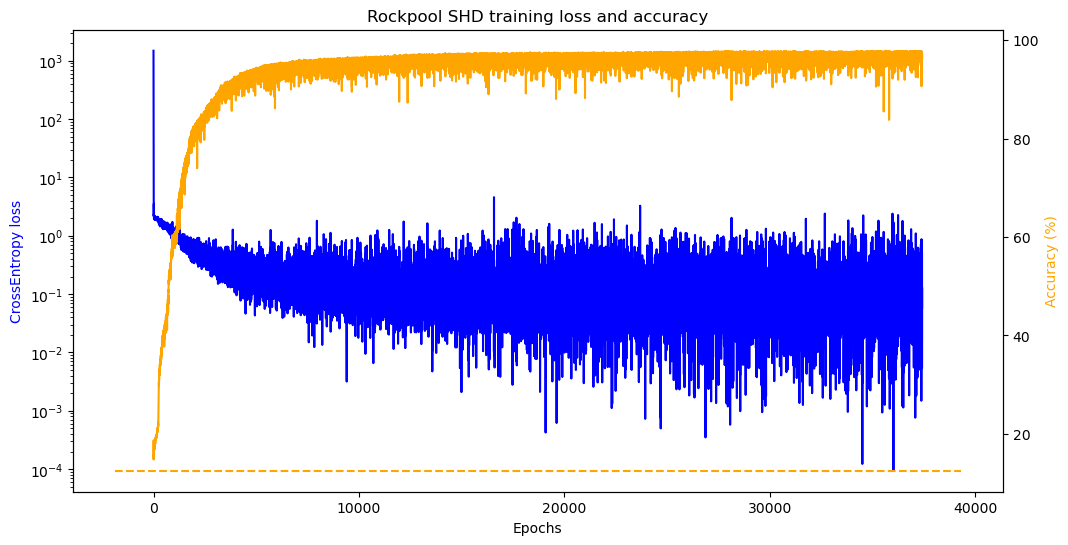

In [32]:
# - Plot the loss curve over training this pre-trained version
Image('loss-pretrained-37ke.png')

In [33]:
# - Evolve the trained network over a training sample
events, label = train_data[2]
out, _, rd = net(events, record = True)

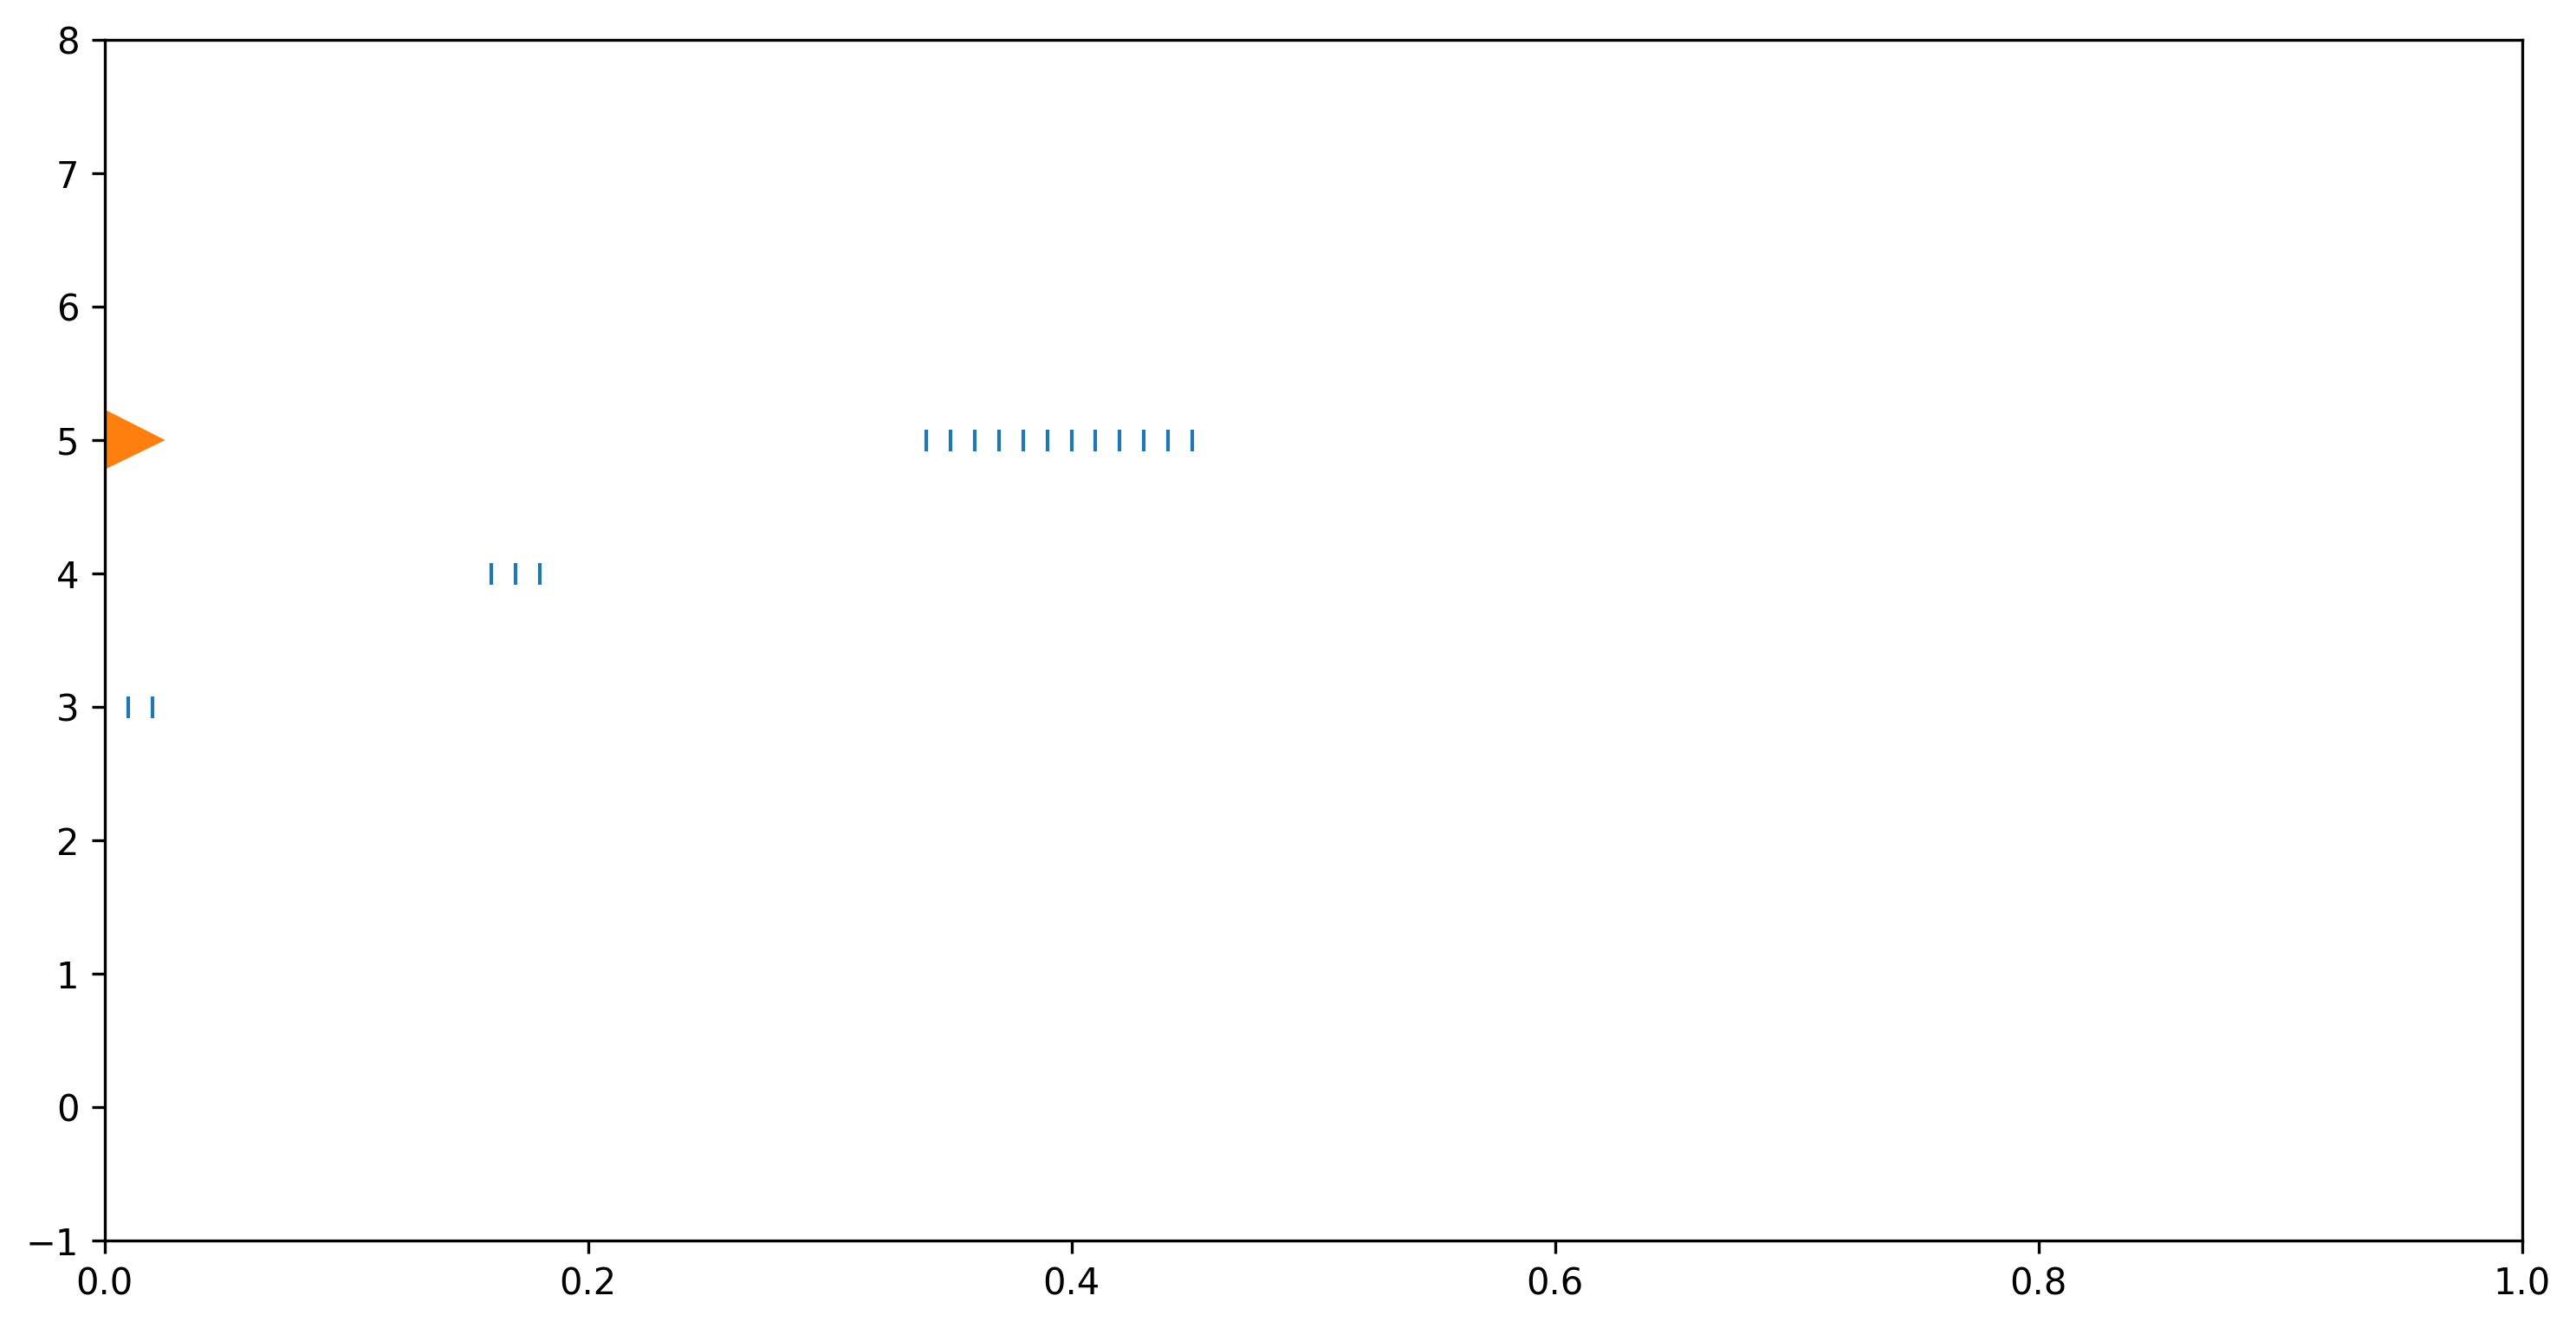

In [34]:
# - Plot the output of the network
times, channels = torch.where(out[0])
plt.plot(times * net_dt, channels, '|')

# - Indicate the target label
plt.plot(0.01, label, '>', ms=18)
plt.ylim([-1, 8])
plt.xlim([0, 1.]);

# BACK TO POWERPOINT to describe Xylo architecture

In [35]:
# - Extract a serialised computational graph from the network
net.as_graph()

GraphHolder "TorchSequential__11208636688" with 16 input nodes -> 8 output nodes

In [36]:
# - Now we need to map and quantise
import rockpool.devices.xylo.syns61201 as xylo

# - Use the `mapper` function to convert the network architecture
spec = xylo.mapper(net.as_graph())
print(spec.keys())

dict_keys(['mapped_graph', 'weights_in', 'weights_out', 'weights_rec', 'dash_mem', 'dash_mem_out', 'dash_syn', 
'dash_syn_2', 'dash_syn_out', 'threshold', 'threshold_out', 'bias', 'bias_out', 'weight_shift_in', 
'weight_shift_rec', 'weight_shift_out', 'aliases', 'dt'])

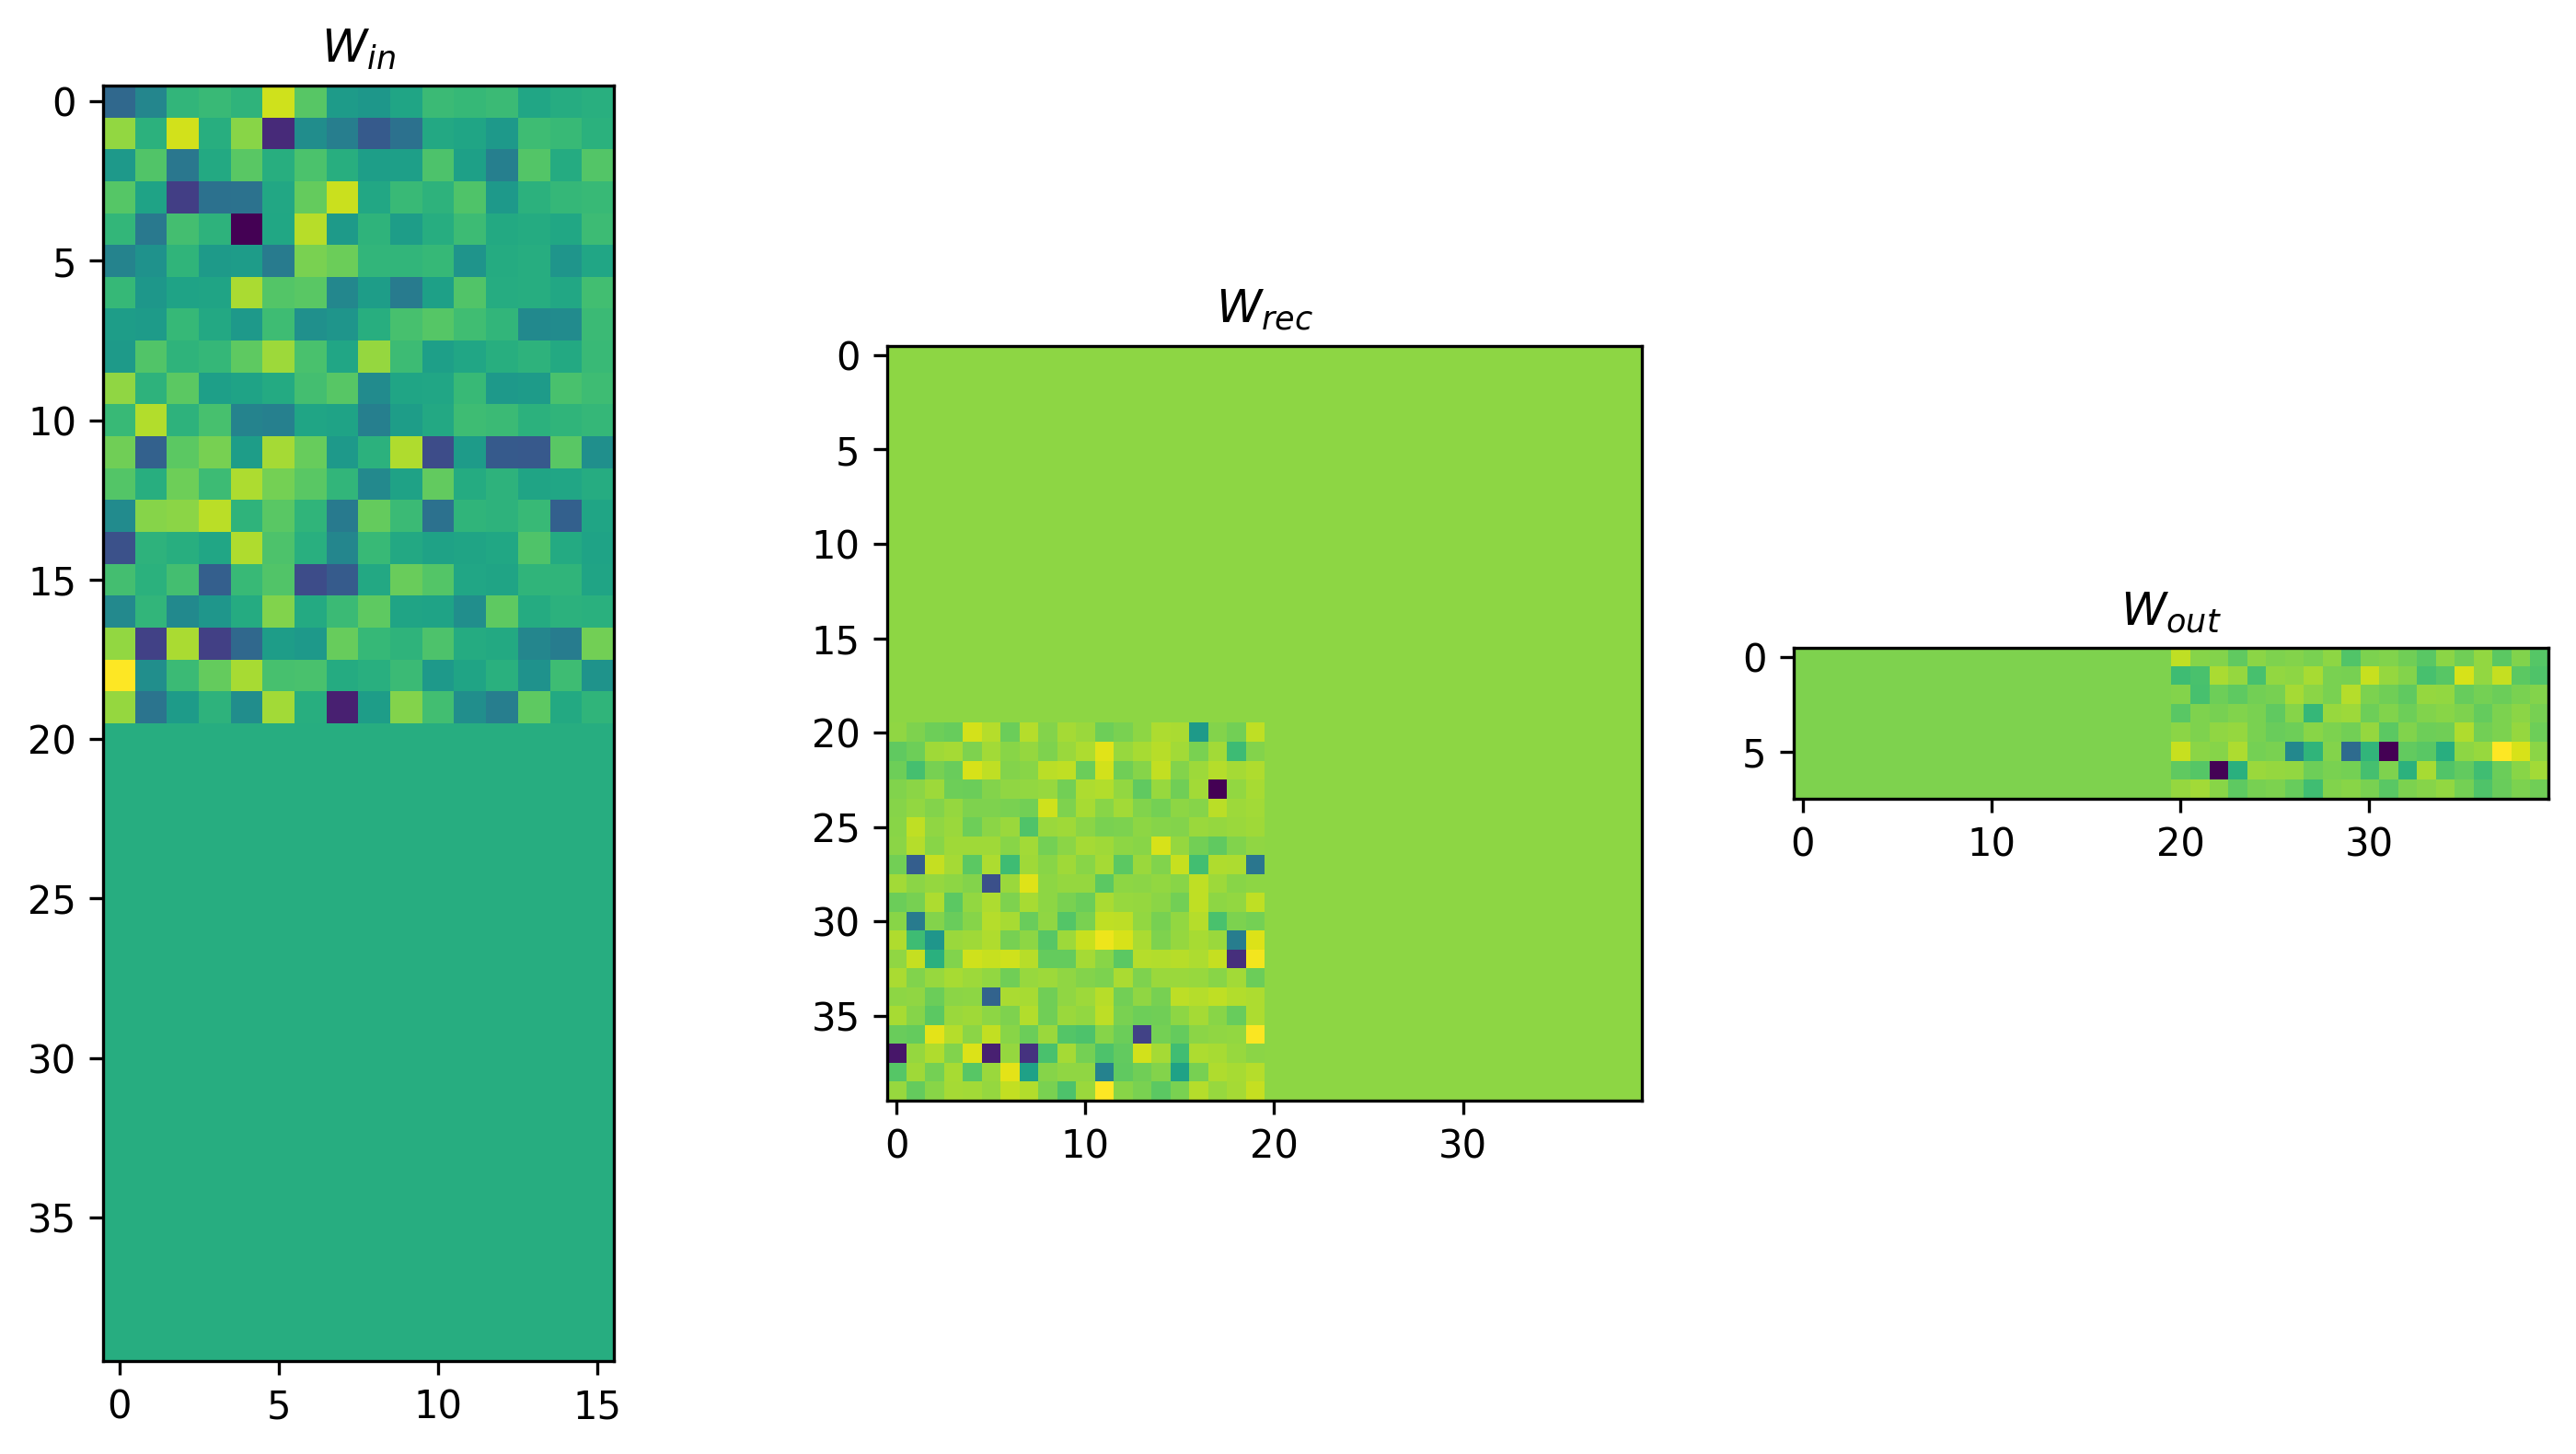

In [37]:
# - Let's look at the mapped weights
plt.subplot(1, 3, 1)
plt.imshow(spec['weights_in'].T)
plt.title('$W_{in}$')

plt.subplot(1, 3, 2)
plt.imshow(spec['weights_rec'].T)
plt.title('$W_{rec}$')

plt.subplot(1, 3, 3)
plt.imshow(spec['weights_out'].T)
plt.title('$W_{out}$');

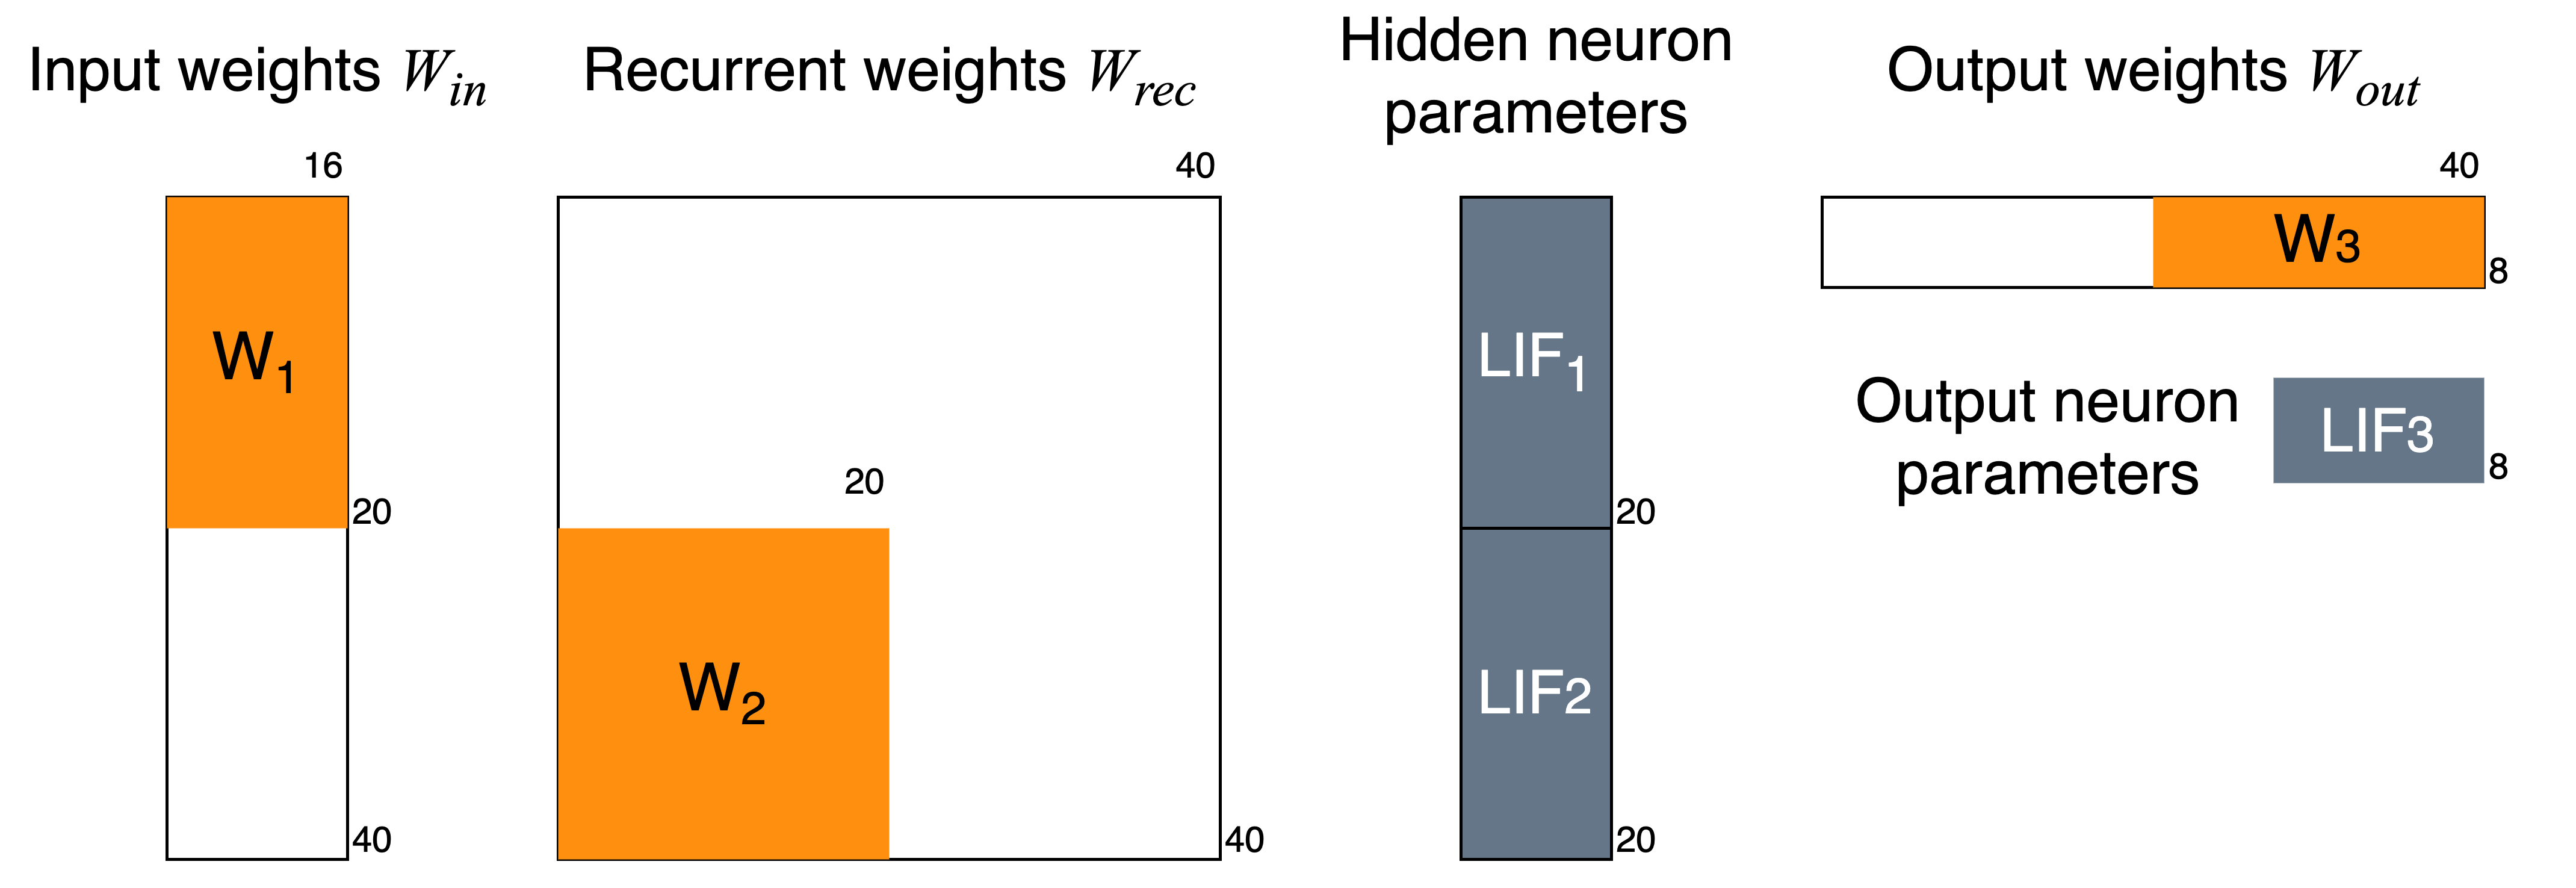

In [38]:
# - Compare this against our assumed solution from before
Image('images/mapped-weights.svg.png')

In [39]:
# - Import the PTQ quantization mini-library
from rockpool.transform.quantize_methods import channel_quantize

# - Quantise the parameters
spec_Q = spec
spec_Q.update(channel_quantize(**spec))

In [40]:
# - Convert to a HW configuration bitstream
config, is_valid, _ = xylo.config_from_specification(**spec_Q)
print(config)

xyloCore2::configuration::XyloConfiguration(operation_mode=OperationMode.Manual, synapse2_enable=0, bias_enable=1, 
direct_fetch_state_ram=0, enable_hibernation_mode=0, clear_network_state=0, time_resolution_wrap=0, 
hibernation_mode_time_resolution_wrap=0, input=xyloCore2::configuration::InputConfig(weight_bit_shift=0, weights={ 
-118 54 -45 32 8 -108 23 -57 -44 127 25 52 55 -56 -127 26 -104 63 127 52 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
-67 5 59 -12 -44 -69 -47 -64 58 14 127 -102 1 78 7 5 22 -126 -43 -57 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 78 
-127 -127 16 19 -23 40 15 76 11 40 79 81 2 25 -99 73 20 -17 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 23 1 -9 -72 5 
-48 -20 -17 24 -35 42 56 31 110 -11 -104 -67 -127 48 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 11 50 67 -71 -127 
-42 127 -70 70 -26 -87 -22 127 11 87 17 -5 -83 83 -31 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 127 -127 3 -6 -5 -127
56 56 127 -7 -91 78 84 48 33 35 127 -19 28 56 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 48 -34 52 41 55 108 62 -103 
49 46 -18 47 60 12 2 -127 -8 -24 30 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -30 -49 2 85 -16 94 -81 -86 -17 71 
-22 -28 18 -84 -56 -109 39 43 -3 -127 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -38 -86 -35 -7 6 23 -34 5 120 -86 -93
6 -77 56 17 -6 85 13 3 -16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -15 -63 -34 16 -13 21 -104 72 34 -21 -33 84 -23 
24 -6 47 -25 8 19 46 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 -5 54 6 0 29 -27 96 -33 -19 -9 -127 69 -100 -16 36 
-30 29 -29 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 19 -8 -30 29 13 -65 54 59 -18 30 32 -24 -4 13 -14 -10 -88 -3 
-13 -31 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 -21 -107 -24 -3 -4 -1 29 2 -49 28 -111 11 9 -10 -13 87 -4 4 -47 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -12 17 61 6 -2 0 0 -127 13 -44 9 -112 -19 21 35 10 -5 -48 -38 30 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -2 12 -4 13 -5 -63 -11 -119 -8 54 16 39 -17 -127 -4 9 13 -60 23 -4 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 3 4 61 15 12 -20 37 51 30 39 20 -41 -2 -14 -15 -13 7 49 -37 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 }, syn2_weights={ 0 }), reservoir=xyloCore2::configuration::ReservoirConfig(weight_bit_shift=0, weights={ 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 -65 -52 -3 -16 -11 -9 -11 7 -84 -3 15 1 92 0 58 -12 -127 -31 12 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 -11 -47 -127 -1 10 88 68 -127 -1 -54 -127 -45 14 -48 1 -21 -14 1 9 -52 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 -24 23 -36 3 -22 1 -9 19 2 68 -5 -95 -36 31 -14 -127 25 8 -13 -6 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 -29 28 -60 -8 14 23 30 8 -1 -127 -18 6 -4 85 -1 26 11 -4 12 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 47 -21 106 -8 -32 -65 32 -19 -4 8 -4 8 18 47 -1 39 -1 19 -30 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 26 25 72 
-2 -31 -8 31 11 -127 67 18 15 16 16 -127 -4 16 -122 6 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -25 -7 -18 1 -43 21
-10 -33 4 -37 12 -12 18 -108 10 -35 -2 2 42 56 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 26 7 -9 1 -60 -127 36 6 25 
57 -19 0 11 29 10 80 -12 -113 -85 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -8 -22 64 2 127 23 -48 -2 -1 -1 1 -29 
-13 49 -12 -71 4 -19 -4 -24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 71 -7 -34 33 -5 6 2 -47 -30 7 -12 7 1 28 
-20 6 0 -84 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 39 -54 7 47 -5 41 -2 2 -87 -10 26 6 -36 6 11 -22 -7 1 12 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -23 108 99 8 -15 -40 [1;3

In [41]:
# - Create an HDK simulator module from the bitstream
mod = xylo.XyloSim.from_config(config, dt = net_dt)
print(mod)

XyloSim  with shape (16, 1000, 8)

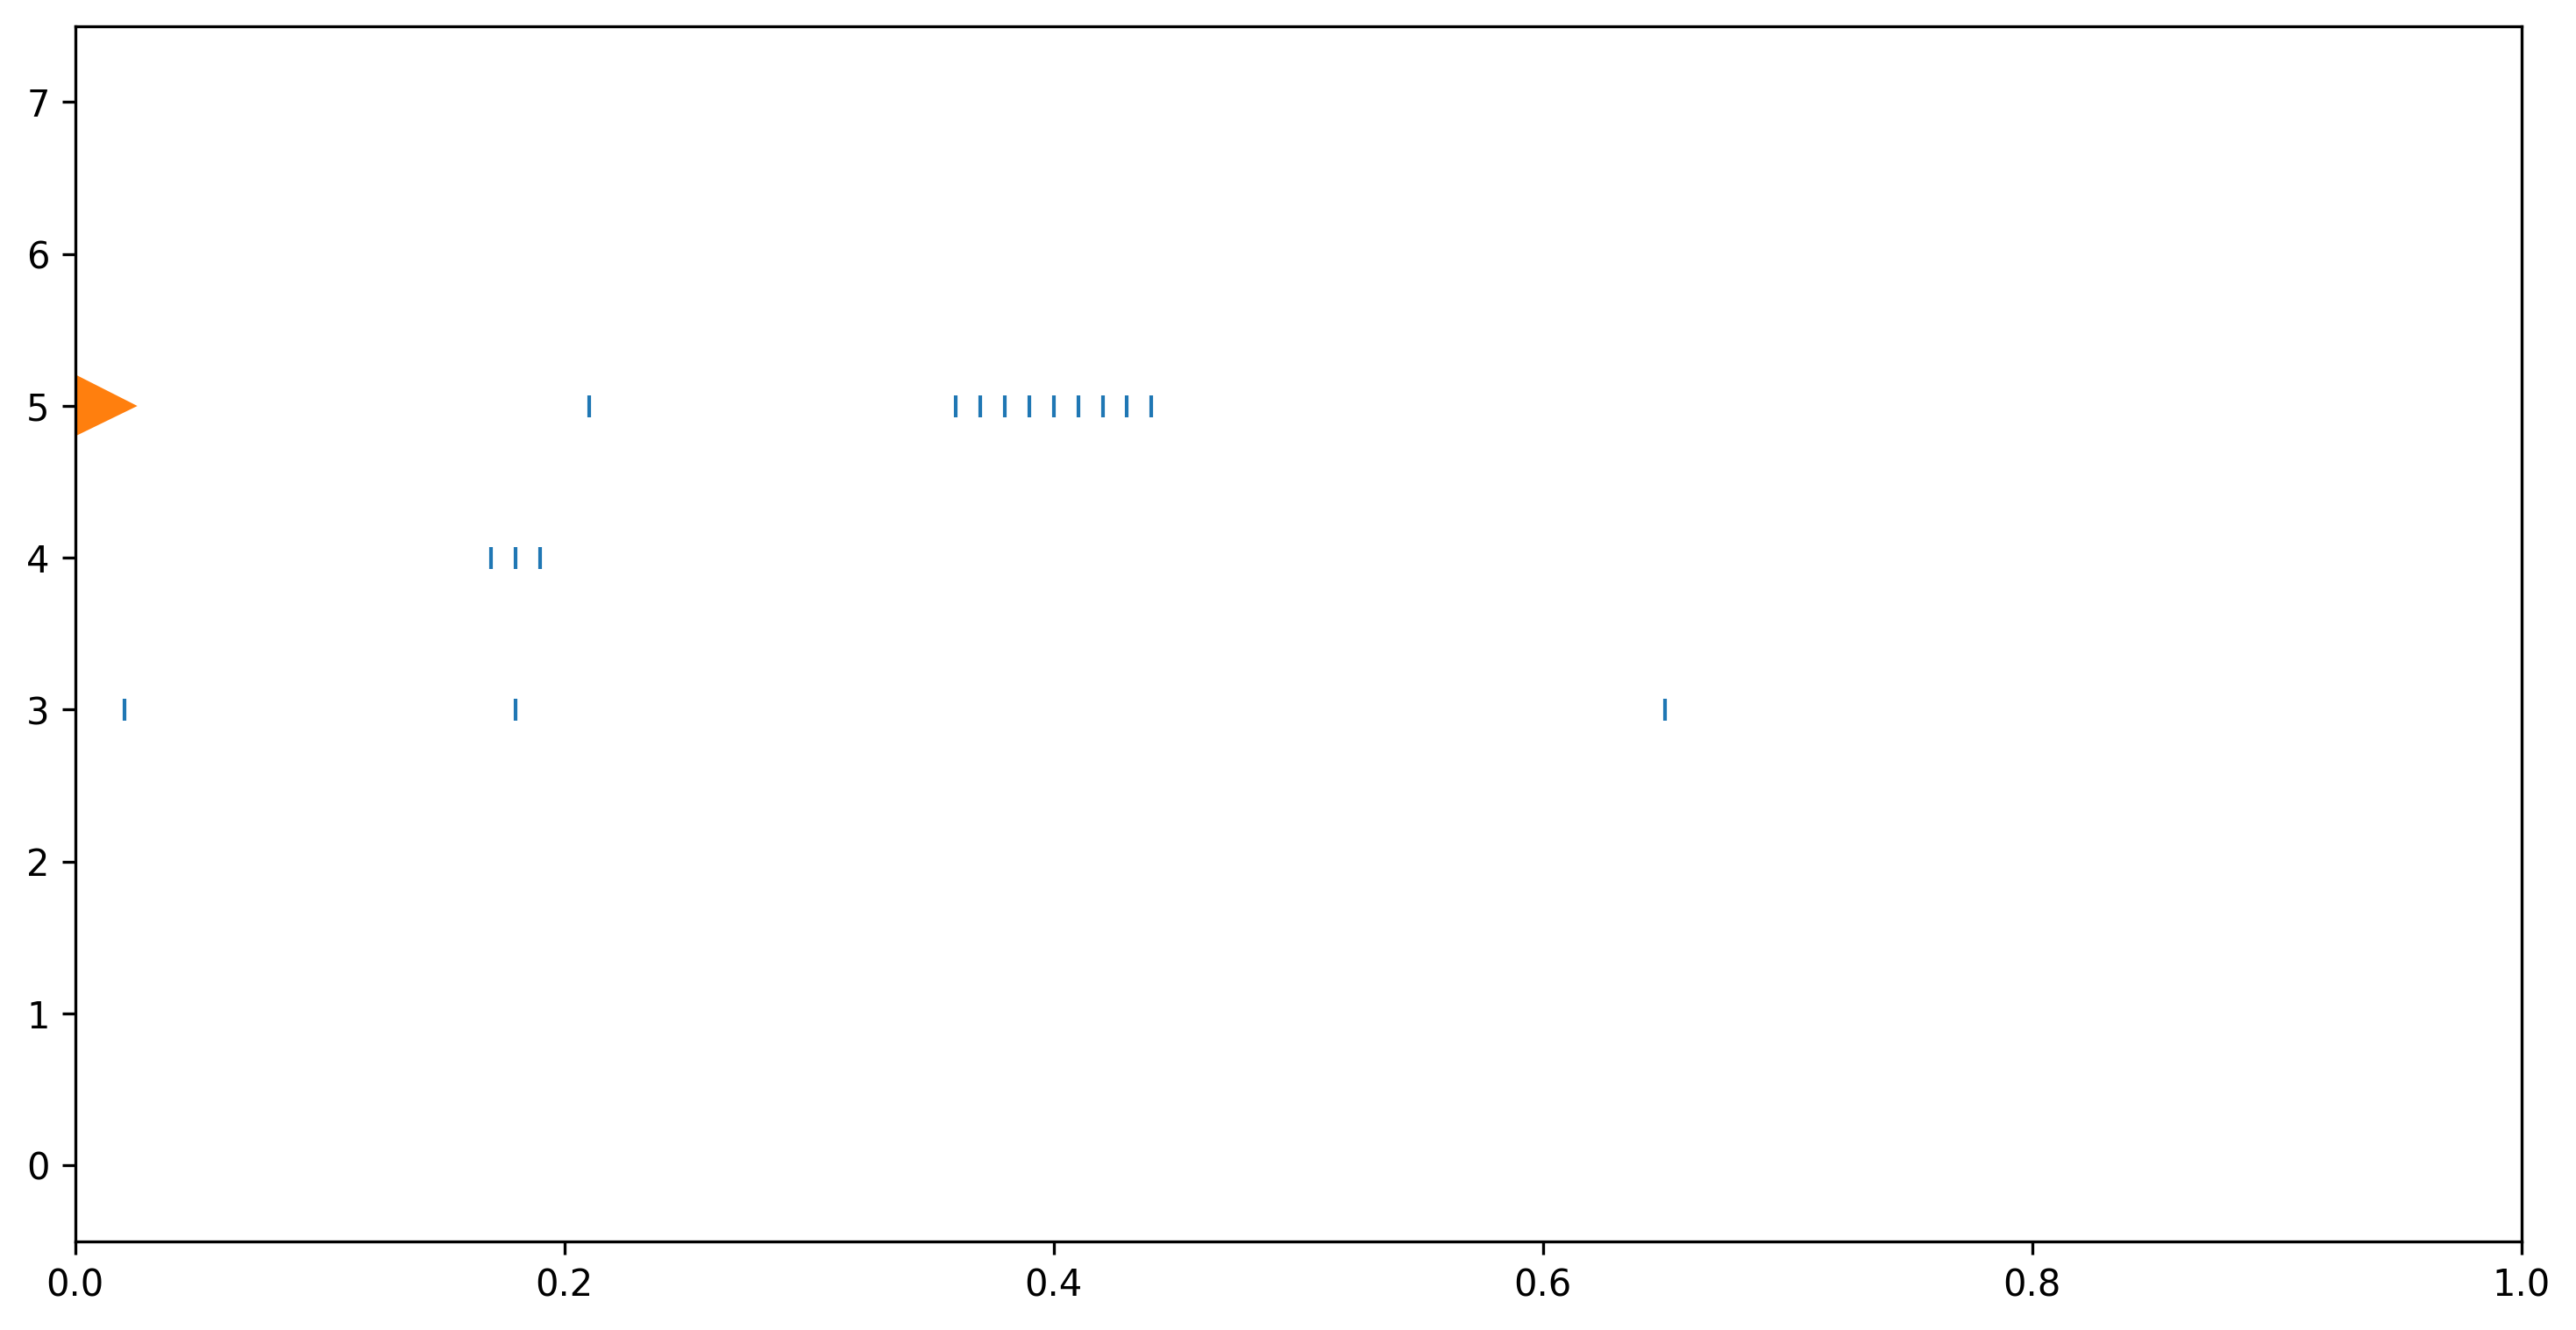

In [42]:
# - Let's look at the output of the simulated HDK on a training sample
events, label = train_data[2]
out_xsim, _, rd_xsim = mod(events.numpy(), record = True)
times, channels = np.nonzero(out_xsim)
plt.plot(times * net_dt, channels, '|')
plt.plot(0.01, label, '>', ms=18)
plt.ylim([-0.5, 7.5])
plt.xlim([0, 1.]);

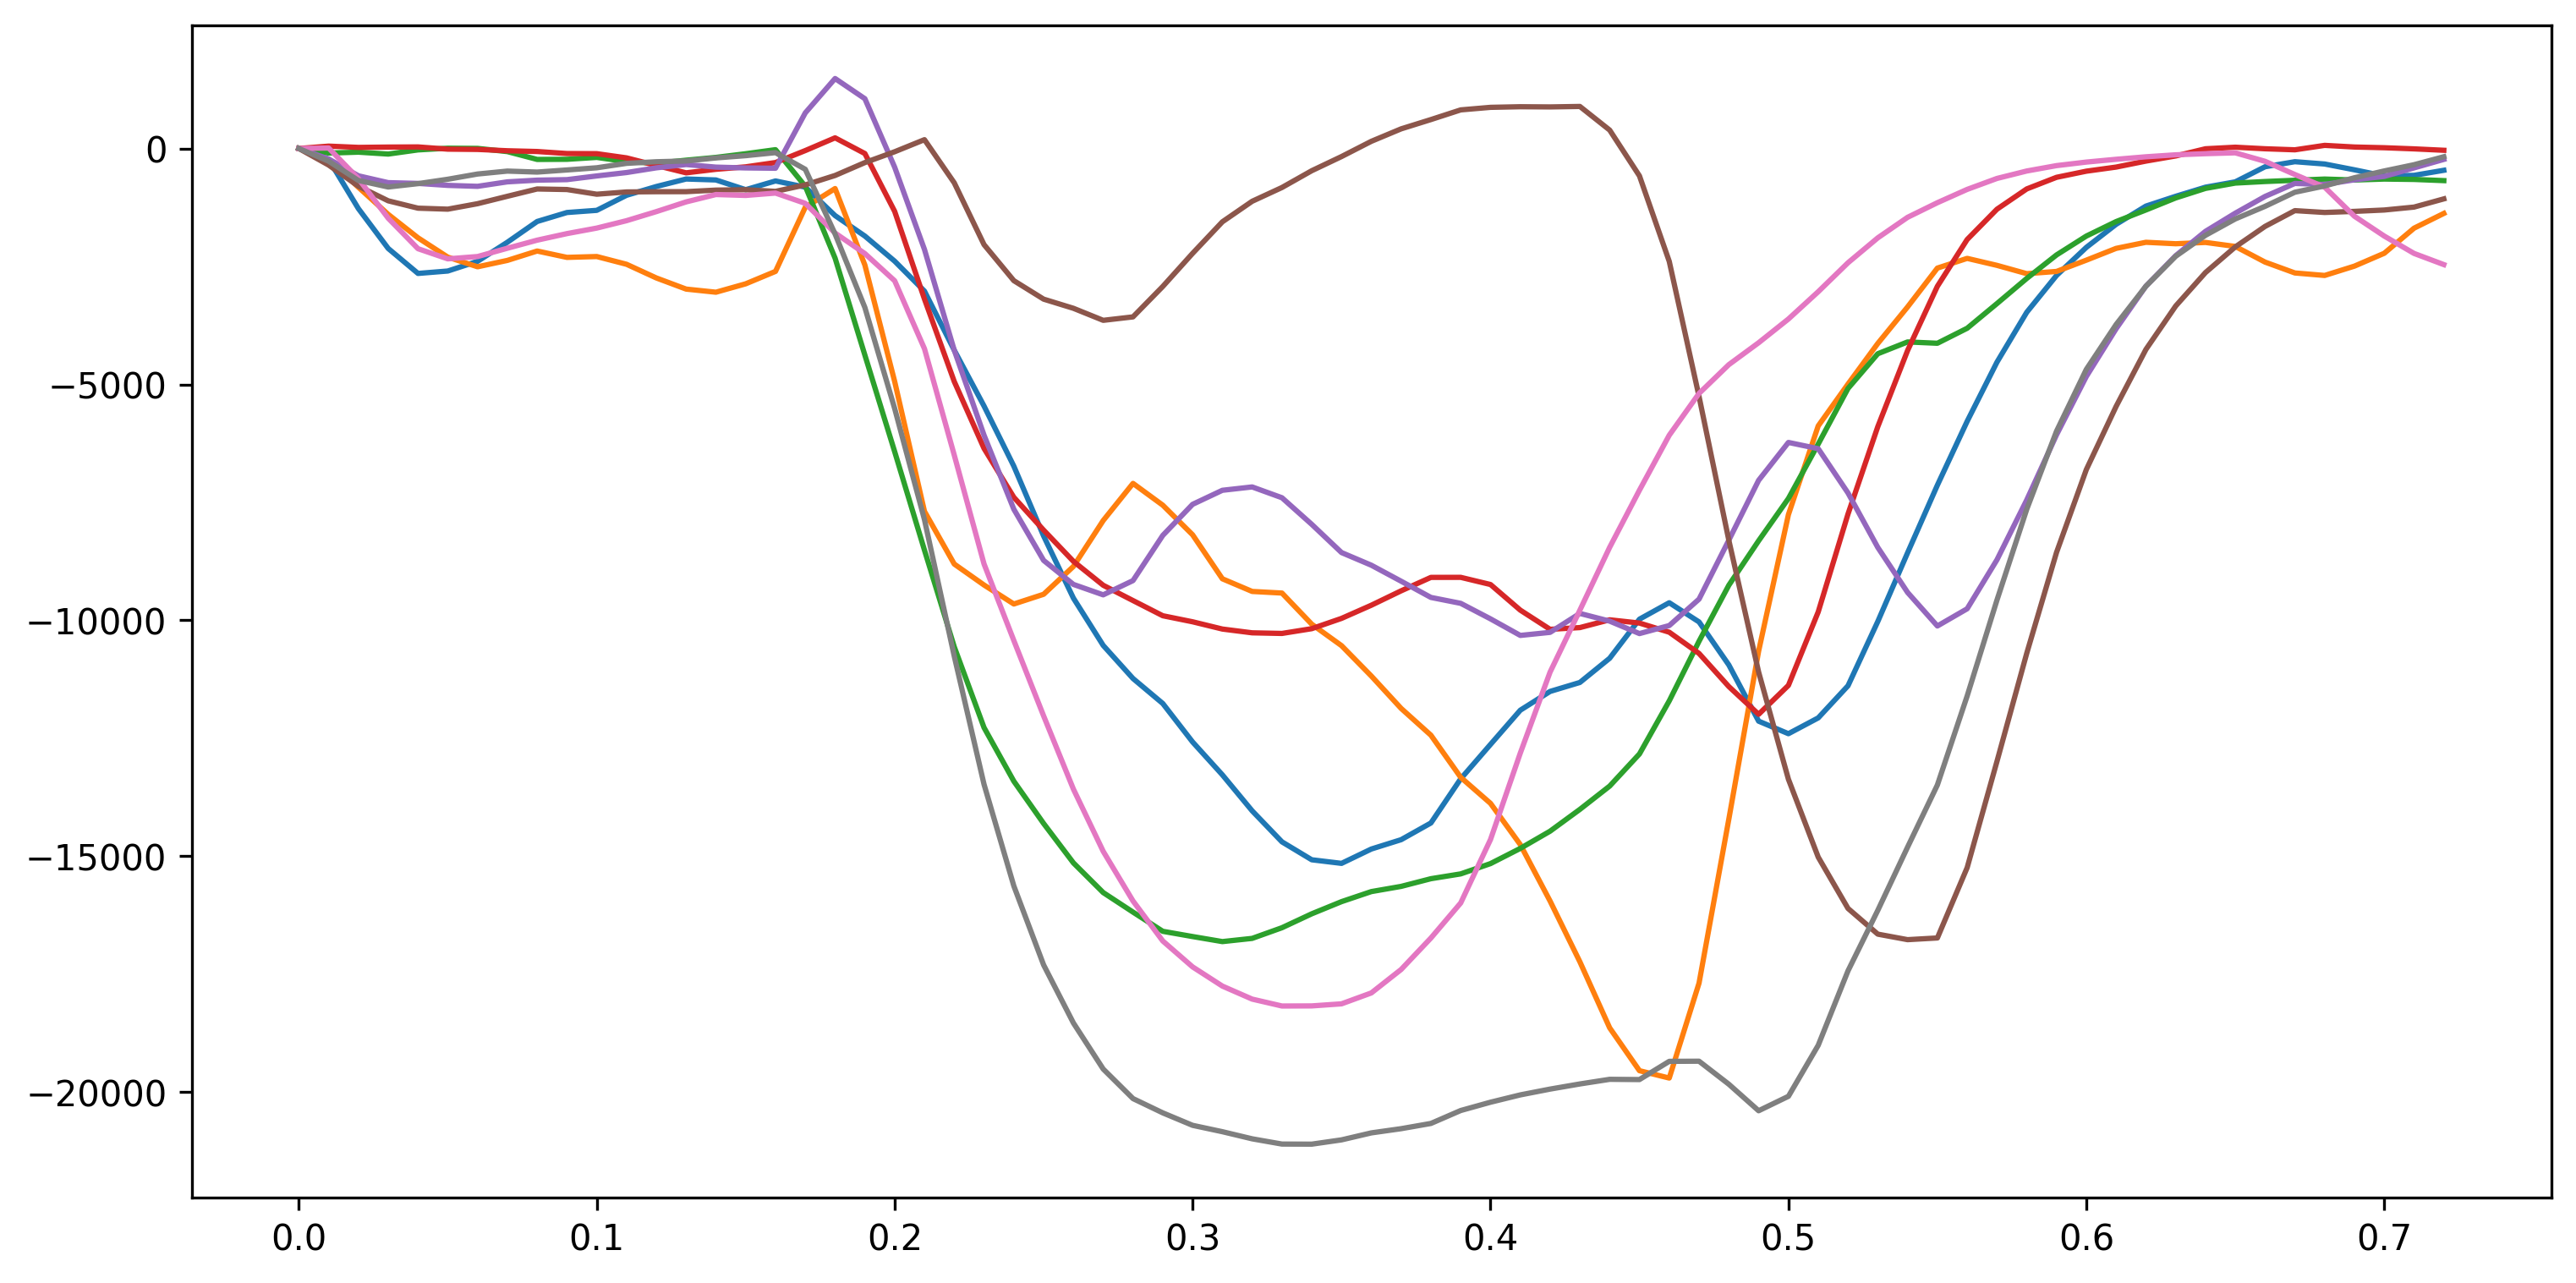

In [43]:
# - Let's plot the membrane potential of the output neurons
times = np.arange(out_xsim.shape[0]) * net_dt
plt.plot(times, rd_xsim['Vmem_out']);

In [44]:
# - Import the helper function to connect to a Xylo HDK
from rockpool.devices.xylo import find_xylo_hdks

In [45]:
# - Locate an HDK, if one is available
hdks, _, _ = find_xylo_hdks()
print(hdks)

assert len(hdks) > 0, 'The rest of this notebook needs a connected Xylo HDK.'

[]

AssertionError: The rest of this notebook needs a connected Xylo HDK.

In [ ]:
# - We'll use the first connected HDK
hdk = hdks[0]

IndexError: list index out of range

In [ ]:
# - Now we can create a Rockpool module that wraps the HDK, by providing the configuration bitstream as before
mod_hdk = xylo.XyloSamna(hdk, config, net_dt)
print(mod_hdk)

XyloSamna  with shape (16, 40, 8)

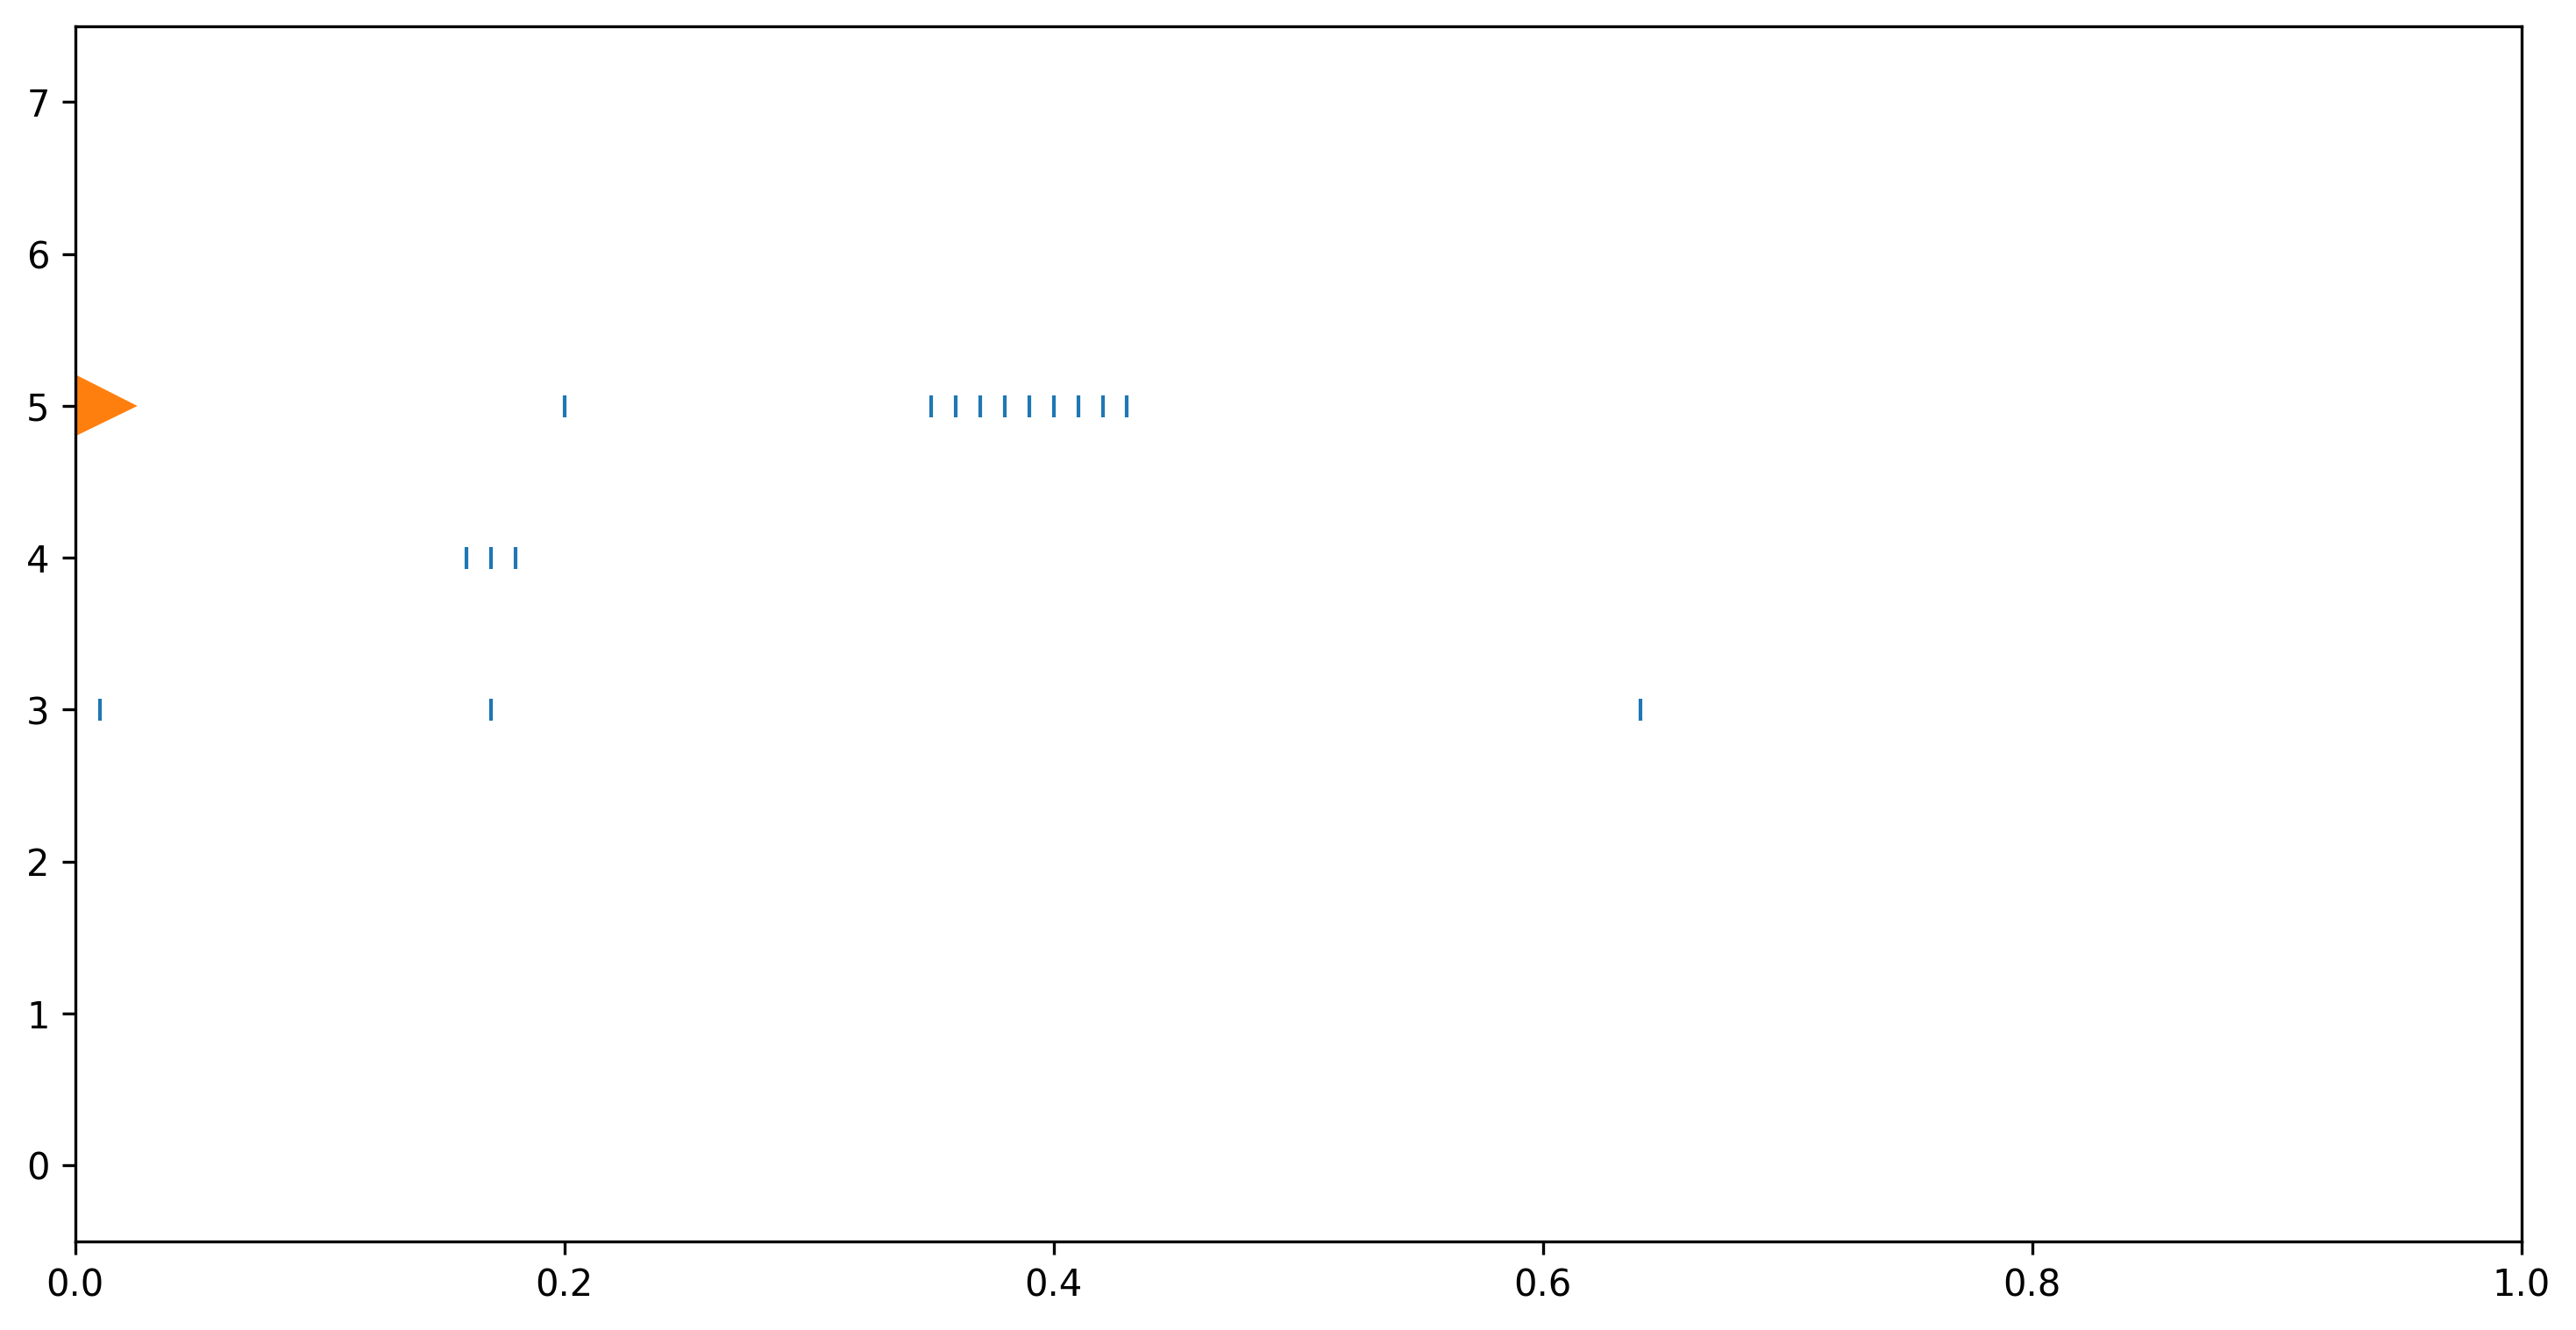

In [ ]:
# - Evolve with a single training sample
events, label = train_data[2]
out_xhdk, _, rd_xhdk = mod_hdk(events.numpy().astype(int), record = True)

# - Plot the output
times, channels = np.nonzero(out_xhdk)
plt.plot(times * net_dt, channels, '|')
plt.plot(0.01, label, '>', ms=18)
plt.ylim([-0.5, 7.5])
plt.xlim([0, 1.]);

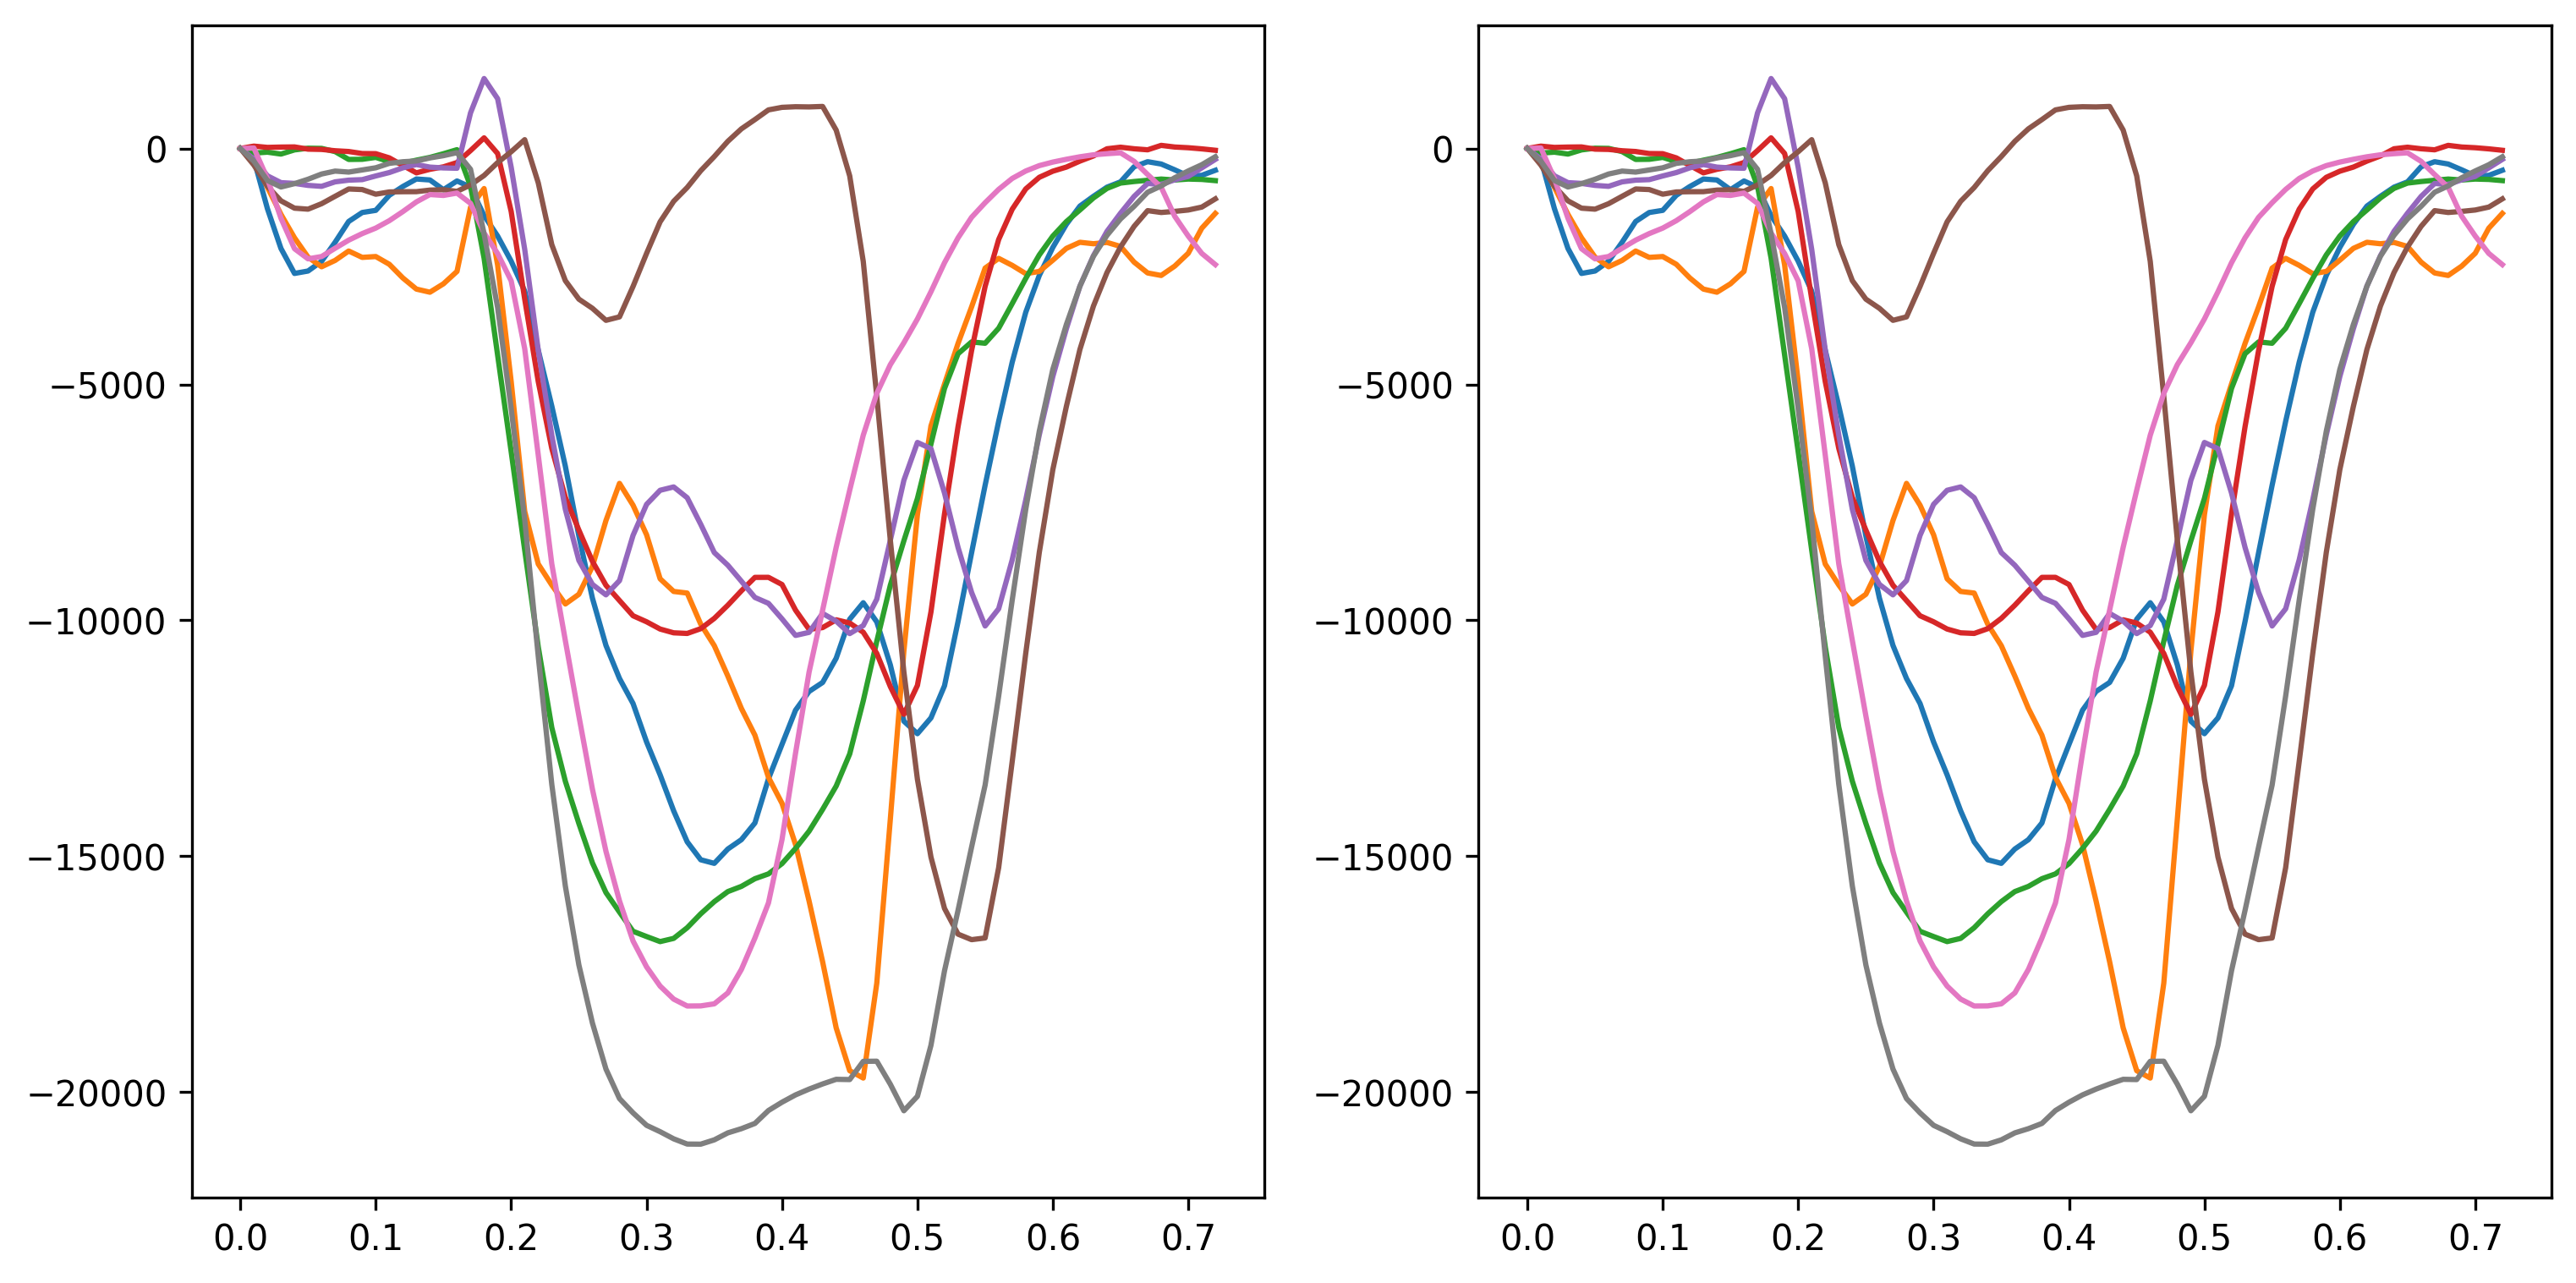

In [ ]:
# - Let's compare the output Vmem between the HDK and the simulator
times = np.arange(out_xhdk.shape[0]) * net_dt
plt.subplot(1, 2, 1)
plt.plot(times, rd_xhdk['Vmem_out'])
plt.subplot(1, 2, 2)
plt.plot(times, rd_xsim['Vmem_out']);

In [ ]:
# - We can also record real-time power consumption from the HDK during evolution
out_xhdk, _, rd_xhdk = mod_hdk(events.numpy().astype(int), record = True, record_power = True)

print(f'Power measurement: {np.mean(rd_xhdk["io_power"]) * 1e6:.2f} muW')

Power measurement: 241.18 muW

## Next steps
Check out further tutorials and documenation on (https://rockpool.ai)!

For more information about Xylo™, see (https://rockpool.ai/devices/xylo-overview.html)

For information about the Xylo™ HDK, see (https://www.synsense.ai/products/xylo/)

For a more in-depth published example, see (https://ieeexplore.ieee.org/document/9967462)(https://doi.org/10.48550/arXiv.2208.12991)